# Phase 4: Superposition-Enhanced Experience Replay

**Notebook:** `04_superposition_replay.ipynb`  
**Phase:** 4 of 9  
**Purpose:** Implement quantum superposition-inspired experience replay for improved sample efficiency  
**Author:** Saurabh Jalendra  
**Institution:** BITS Pilani (WILP Division)  
**Date:** November 2025

---

## Table of Contents

1. [Setup & Imports](#1-setup--imports)
2. [Superposition Concept](#2-superposition-concept)
3. [Amplitude-Based Weighting](#3-amplitude-based-weighting)
4. [Interference Effects](#4-interference-effects)
5. [Superposition Replay Buffer](#5-superposition-replay-buffer)
6. [Integration with World Model](#6-integration-with-world-model)
7. [Experiments](#7-experiments)
8. [Comparison with Standard Replay](#8-comparison-with-standard-replay)
9. [Visualizations](#9-visualizations)
10. [Summary](#10-summary)

---
## 1. Setup & Imports

In [41]:
"""
Cell: Imports and Configuration
Purpose: Import packages and set up environment
"""

import os
import sys
import math
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Union, Any, NamedTuple
from dataclasses import dataclass, field
from collections import deque
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import gymnasium as gym

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from tqdm.notebook import tqdm

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

from utils import set_seed, get_device, MetricLogger, COLORS

SEED = 42
set_seed(SEED)
DEVICE = get_device()

print(f"Device: {DEVICE}")
print(f"PyTorch: {torch.__version__}")

Device: cuda
PyTorch: 2.10.0.dev20251124+cu128


In [42]:
"""
Cell: World Model Components (from Phase 2)
Purpose: Import world model architecture
"""

# Core world model components (condensed from previous phases)
class RSSMState(NamedTuple):
    deter: torch.Tensor
    stoch: torch.Tensor
    @property
    def combined(self): return torch.cat([self.deter, self.stoch], dim=-1)

class MLPEncoder(nn.Module):
    def __init__(self, obs_dim, hidden_dims, latent_dim):
        super().__init__()
        layers = []
        in_dim = obs_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(in_dim, hd), nn.ELU()])
            in_dim = hd
        layers.append(nn.Linear(in_dim, latent_dim))
        self.network = nn.Sequential(*layers)
    def forward(self, obs): return self.network(obs)

class MLPDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, obs_dim):
        super().__init__()
        layers = []
        in_dim = latent_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(in_dim, hd), nn.ELU()])
            in_dim = hd
        layers.append(nn.Linear(in_dim, obs_dim))
        self.network = nn.Sequential(*layers)
    def forward(self, latent): return self.network(latent)

class RSSM(nn.Module):
    def __init__(self, stoch_dim, deter_dim, hidden_dim, action_dim, embed_dim, min_std=0.1):
        super().__init__()
        self.stoch_dim, self.deter_dim, self.min_std = stoch_dim, deter_dim, min_std
        self.input_proj = nn.Sequential(nn.Linear(stoch_dim + action_dim, hidden_dim), nn.ELU())
        self.gru = nn.GRUCell(hidden_dim, deter_dim)
        self.prior_net = nn.Sequential(nn.Linear(deter_dim, hidden_dim), nn.ELU(), nn.Linear(hidden_dim, 2*stoch_dim))
        self.posterior_net = nn.Sequential(nn.Linear(deter_dim + embed_dim, hidden_dim), nn.ELU(), nn.Linear(hidden_dim, 2*stoch_dim))
    
    def initial_state(self, batch_size, device):
        return RSSMState(torch.zeros(batch_size, self.deter_dim, device=device),
                        torch.zeros(batch_size, self.stoch_dim, device=device))
    
    def _get_dist(self, stats):
        mean, std = torch.chunk(stats, 2, dim=-1)
        return Normal(mean, F.softplus(std) + self.min_std)
    
    def imagine_step(self, prev_state, action):
        x = self.input_proj(torch.cat([prev_state.stoch, action], dim=-1))
        deter = self.gru(x, prev_state.deter)
        prior_dist = self._get_dist(self.prior_net(deter))
        return RSSMState(deter, prior_dist.rsample()), prior_dist
    
    def observe_step(self, prev_state, action, embed):
        prior_state, prior_dist = self.imagine_step(prev_state, action)
        posterior_dist = self._get_dist(self.posterior_net(torch.cat([prior_state.deter, embed], dim=-1)))
        return RSSMState(prior_state.deter, posterior_dist.rsample()), prior_dist, posterior_dist

class RewardPredictor(nn.Module):
    def __init__(self, state_dim, hidden_dims):
        super().__init__()
        layers = []
        in_dim = state_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(in_dim, hd), nn.ELU()])
            in_dim = hd
        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)
    def forward(self, state): return self.network(state).squeeze(-1)

class ContinuePredictor(nn.Module):
    def __init__(self, state_dim, hidden_dims):
        super().__init__()
        layers = []
        in_dim = state_dim
        for hd in hidden_dims:
            layers.extend([nn.Linear(in_dim, hd), nn.ELU()])
            in_dim = hd
        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)
    def forward(self, state): return self.network(state).squeeze(-1)

class WorldModel(nn.Module):
    def __init__(self, obs_dim, action_dim, stoch_dim=32, deter_dim=256, hidden_dim=256,
                 encoder_hidden=[256,256], decoder_hidden=[256,256], predictor_hidden=[256,256]):
        super().__init__()
        self.state_dim = stoch_dim + deter_dim
        self.encoder = MLPEncoder(obs_dim, encoder_hidden, hidden_dim)
        self.rssm = RSSM(stoch_dim, deter_dim, hidden_dim, action_dim, hidden_dim)
        self.reward_predictor = RewardPredictor(self.state_dim, predictor_hidden)
        self.continue_predictor = ContinuePredictor(self.state_dim, predictor_hidden)
        self.decoder = MLPDecoder(self.state_dim, decoder_hidden, obs_dim)
    
    def initial_state(self, batch_size):
        return self.rssm.initial_state(batch_size, next(self.parameters()).device)
    
    def observe(self, obs, action, prev_state):
        return self.rssm.observe_step(prev_state, action, self.encoder(obs))
    
    def predict(self, state):
        combined = state.combined
        return self.decoder(combined), self.reward_predictor(combined), self.continue_predictor(combined)
    
    def forward(self, obs_seq, action_seq):
        B, T, _ = obs_seq.shape
        state = self.initial_state(B)
        priors, posteriors, recon_obs, pred_rewards, pred_continues = [], [], [], [], []
        for t in range(T):
            state, prior, posterior = self.observe(obs_seq[:, t], action_seq[:, t], state)
            recon, reward, cont = self.predict(state)
            priors.append(prior); posteriors.append(posterior)
            recon_obs.append(recon); pred_rewards.append(reward); pred_continues.append(cont)
        return {'recon_obs': torch.stack(recon_obs, 1), 'pred_rewards': torch.stack(pred_rewards, 1),
                'pred_continues': torch.stack(pred_continues, 1), 'priors': priors, 'posteriors': posteriors}

print("World model components loaded.")

World model components loaded.


---
## 2. Superposition Concept

In quantum mechanics, superposition allows a system to exist in multiple states simultaneously.
For experience replay, we implement this as:

1. **Parallel sampling**: Sample multiple trajectories simultaneously
2. **Amplitude weighting**: Assign quantum-like amplitudes to each sample
3. **Interference**: Allow positive/negative interference between samples

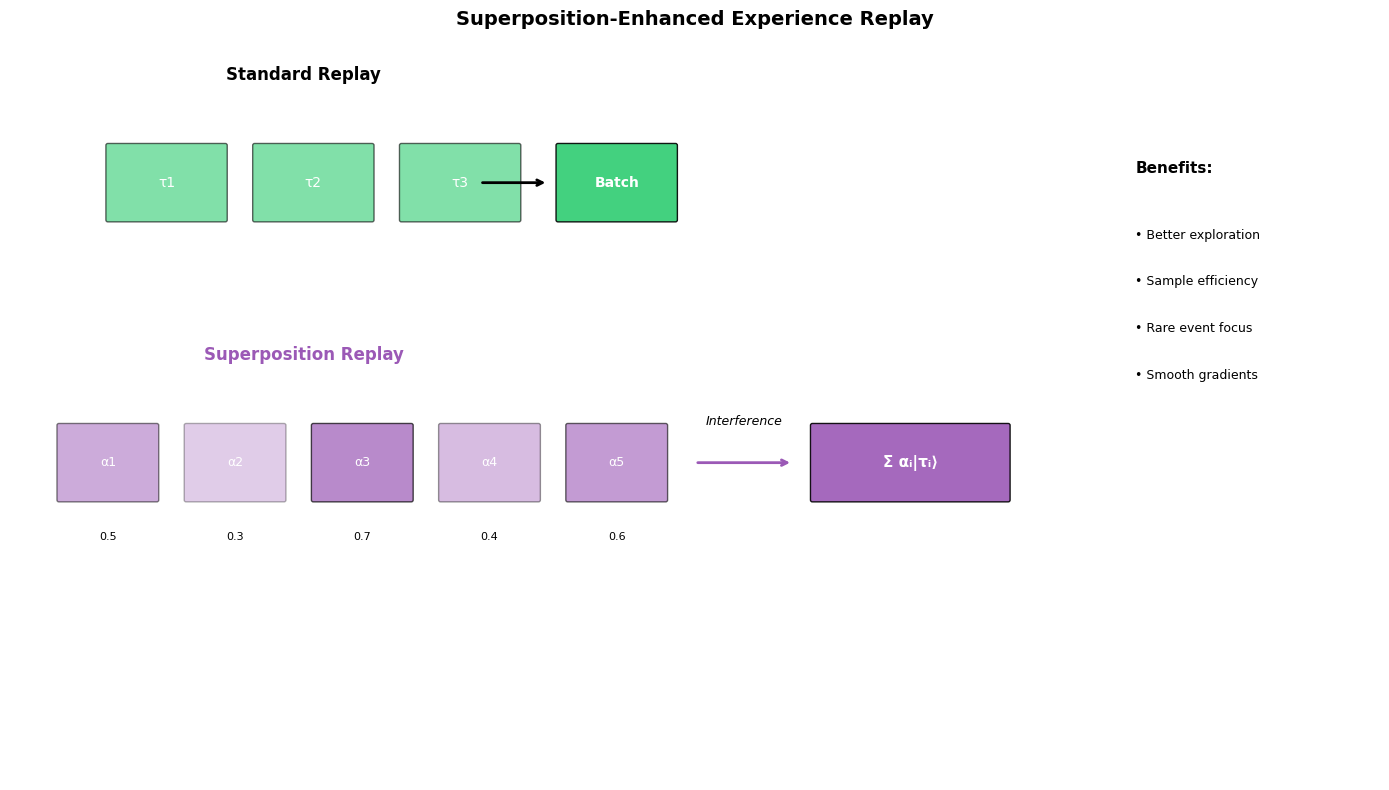

In [43]:
"""
Cell: Superposition Concept Diagram
Purpose: Visualize the superposition-enhanced replay concept
"""

def create_superposition_diagram(figsize=(14, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Standard replay
    ax.text(3, 7.5, 'Standard Replay', ha='center', fontsize=12, fontweight='bold')
    for i in range(3):
        rect = mpatches.FancyBboxPatch((1+i*1.5, 6), 1.2, 0.8, boxstyle="round,pad=0.02",
                                       facecolor=COLORS['baseline'], alpha=0.6)
        ax.add_patch(rect)
        ax.text(1.6+i*1.5, 6.4, f'τ{i+1}', ha='center', va='center', fontsize=10, color='white')
    ax.annotate('', xy=(5.5, 6.4), xytext=(4.8, 6.4), arrowprops=dict(arrowstyle='->', lw=2))
    rect = mpatches.FancyBboxPatch((5.6, 6), 1.2, 0.8, boxstyle="round,pad=0.02",
                                   facecolor=COLORS['baseline'], alpha=0.9)
    ax.add_patch(rect)
    ax.text(6.2, 6.4, 'Batch', ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    
    # Superposition replay
    ax.text(3, 4.5, 'Superposition Replay', ha='center', fontsize=12, fontweight='bold', color=COLORS['superposition'])
    
    # Parallel samples with amplitudes
    amplitudes = [0.5, 0.3, 0.7, 0.4, 0.6]
    for i, amp in enumerate(amplitudes):
        rect = mpatches.FancyBboxPatch((0.5+i*1.3, 3), 1.0, 0.8, boxstyle="round,pad=0.02",
                                       facecolor=COLORS['superposition'], alpha=amp)
        ax.add_patch(rect)
        ax.text(1.0+i*1.3, 3.4, f'α{i+1}', ha='center', va='center', fontsize=9, color='white')
        ax.text(1.0+i*1.3, 2.6, f'{amp}', ha='center', va='center', fontsize=8)
    
    # Interference
    ax.annotate('', xy=(8, 3.4), xytext=(7, 3.4), arrowprops=dict(arrowstyle='->', lw=2, color=COLORS['superposition']))
    ax.text(7.5, 3.8, 'Interference', ha='center', fontsize=9, style='italic')
    
    # Weighted combination
    rect = mpatches.FancyBboxPatch((8.2, 3), 2, 0.8, boxstyle="round,pad=0.02",
                                   facecolor=COLORS['superposition'], alpha=0.9)
    ax.add_patch(rect)
    ax.text(9.2, 3.4, 'Σ αᵢ|τᵢ⟩', ha='center', va='center', fontsize=11, color='white', fontweight='bold')
    
    # Benefits
    ax.text(11.5, 6.5, 'Benefits:', fontsize=11, fontweight='bold')
    benefits = ['• Better exploration', '• Sample efficiency', '• Rare event focus', '• Smooth gradients']
    for i, b in enumerate(benefits):
        ax.text(11.5, 5.8-i*0.5, b, fontsize=9)
    
    ax.set_title('Superposition-Enhanced Experience Replay', fontsize=14, fontweight='bold')
    return fig

fig = create_superposition_diagram()
plt.tight_layout()
plt.show()

---
## 3. Amplitude-Based Weighting

Assign quantum-like amplitudes to experiences based on their importance.

In [44]:
"""
Cell: Amplitude Calculator
Purpose: Compute quantum-inspired amplitudes for experiences
"""

class AmplitudeCalculator:
    """
    Calculate quantum-inspired amplitudes for experience weighting.
    
    Amplitudes are computed based on:
    - TD error (surprise/novelty)
    - Reward magnitude
    - Recency
    - State entropy
    
    Parameters
    ----------
    td_weight : float
        Weight for TD error component
    reward_weight : float
        Weight for reward magnitude
    recency_weight : float
        Weight for recency (newer = higher)
    entropy_weight : float
        Weight for state entropy
    temperature : float
        Softmax temperature for amplitude normalization
    """
    
    def __init__(
        self,
        td_weight: float = 0.4,
        reward_weight: float = 0.3,
        recency_weight: float = 0.2,
        entropy_weight: float = 0.1,
        temperature: float = 1.0
    ):
        self.td_weight = td_weight
        self.reward_weight = reward_weight
        self.recency_weight = recency_weight
        self.entropy_weight = entropy_weight
        self.temperature = temperature
    
    def compute_td_priority(
        self,
        rewards: np.ndarray,
        gamma: float = 0.99
    ) -> np.ndarray:
        """
        Compute TD-error based priority.
        Uses reward variance as proxy for TD error.
        """
        # Compute reward changes
        reward_diff = np.abs(np.diff(rewards, prepend=rewards[0]))
        return reward_diff / (reward_diff.max() + 1e-8)
    
    def compute_reward_priority(self, rewards: np.ndarray) -> np.ndarray:
        """
        Compute reward magnitude priority.
        Higher absolute rewards get higher priority.
        """
        abs_rewards = np.abs(rewards)
        return abs_rewards / (abs_rewards.max() + 1e-8)
    
    def compute_recency_priority(self, length: int, decay: float = 0.99) -> np.ndarray:
        """
        Compute recency-based priority.
        More recent experiences get higher priority.
        """
        indices = np.arange(length)
        return decay ** (length - 1 - indices)
    
    def compute_entropy_priority(self, observations: np.ndarray) -> np.ndarray:
        """
        Compute state entropy priority.
        Higher entropy (more diverse) states get higher priority.
        """
        # Use observation variance as proxy for entropy
        obs_var = np.var(observations, axis=-1)
        return obs_var / (obs_var.max() + 1e-8)
    
    def compute_amplitudes(
        self,
        observations: np.ndarray,
        rewards: np.ndarray
    ) -> np.ndarray:
        """
        Compute quantum-inspired amplitudes for a trajectory.
        
        Parameters
        ----------
        observations : np.ndarray
            Trajectory observations (T, obs_dim)
        rewards : np.ndarray
            Trajectory rewards (T,)
        
        Returns
        -------
        np.ndarray
            Amplitudes (T,) that sum to 1 (like probability amplitudes squared)
        """
        length = len(rewards)
        
        # Compute individual priorities
        td_priority = self.compute_td_priority(rewards)
        reward_priority = self.compute_reward_priority(rewards)
        recency_priority = self.compute_recency_priority(length)
        entropy_priority = self.compute_entropy_priority(observations)
        
        # Weighted combination
        combined = (
            self.td_weight * td_priority +
            self.reward_weight * reward_priority +
            self.recency_weight * recency_priority +
            self.entropy_weight * entropy_priority
        )
        
        # Softmax normalization (temperature-scaled)
        amplitudes = np.exp(combined / self.temperature)
        amplitudes = amplitudes / amplitudes.sum()
        
        return amplitudes


# Test amplitude calculator
amp_calc = AmplitudeCalculator()

test_obs = np.random.randn(50, 4)
test_rewards = np.sin(np.linspace(0, 4*np.pi, 50)) + np.random.randn(50) * 0.1

amplitudes = amp_calc.compute_amplitudes(test_obs, test_rewards)

print(f"Amplitudes shape: {amplitudes.shape}")
print(f"Amplitudes sum: {amplitudes.sum():.4f}")
print(f"Max amplitude: {amplitudes.max():.4f}")
print(f"Min amplitude: {amplitudes.min():.4f}")

Amplitudes shape: (50,)
Amplitudes sum: 1.0000
Max amplitude: 0.0244
Min amplitude: 0.0139


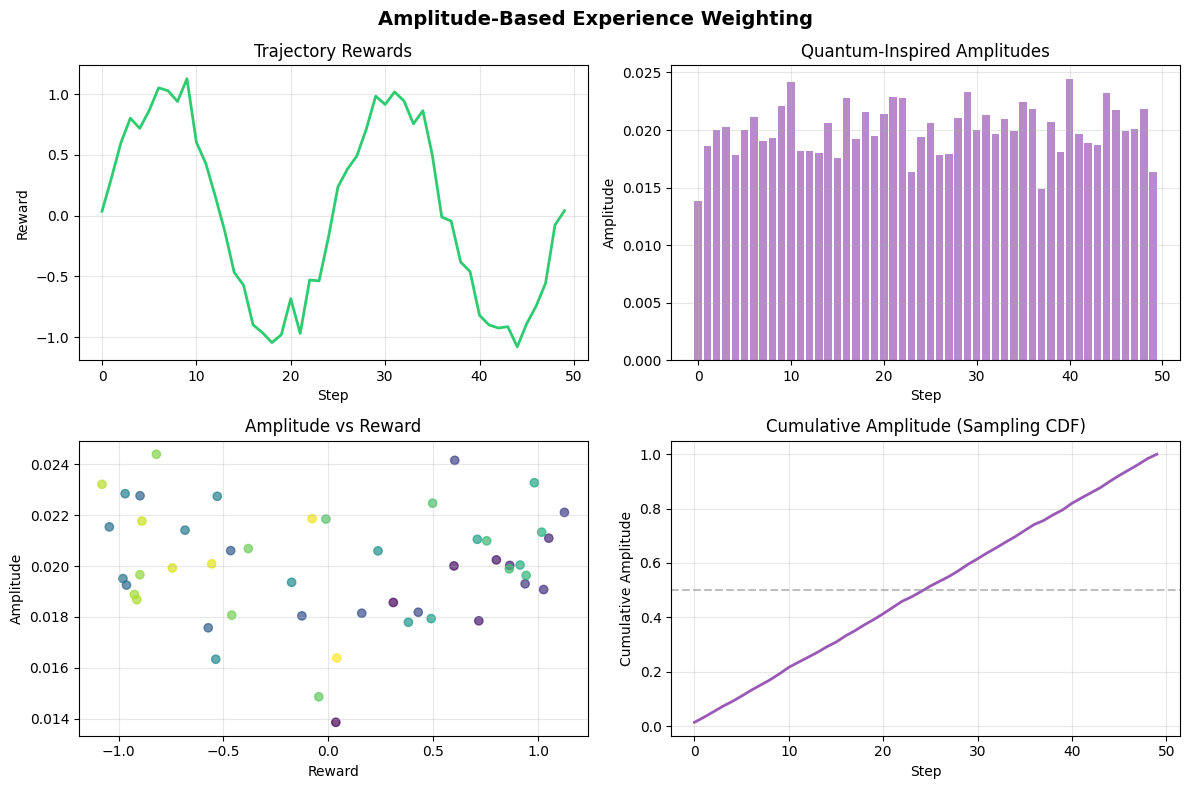

In [45]:
"""
Cell: Visualize Amplitudes
Purpose: Plot amplitude distribution for a trajectory
"""

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Rewards
ax = axes[0, 0]
ax.plot(test_rewards, color=COLORS['baseline'], linewidth=2)
ax.set_xlabel('Step')
ax.set_ylabel('Reward')
ax.set_title('Trajectory Rewards')
ax.grid(True, alpha=0.3)

# Amplitudes
ax = axes[0, 1]
ax.bar(range(len(amplitudes)), amplitudes, color=COLORS['superposition'], alpha=0.7)
ax.set_xlabel('Step')
ax.set_ylabel('Amplitude')
ax.set_title('Quantum-Inspired Amplitudes')
ax.grid(True, alpha=0.3)

# Amplitude vs Reward
ax = axes[1, 0]
ax.scatter(test_rewards, amplitudes, c=range(len(amplitudes)), cmap='viridis', alpha=0.7)
ax.set_xlabel('Reward')
ax.set_ylabel('Amplitude')
ax.set_title('Amplitude vs Reward')
ax.grid(True, alpha=0.3)

# Cumulative amplitude
ax = axes[1, 1]
ax.plot(np.cumsum(amplitudes), color=COLORS['superposition'], linewidth=2)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Step')
ax.set_ylabel('Cumulative Amplitude')
ax.set_title('Cumulative Amplitude (Sampling CDF)')
ax.grid(True, alpha=0.3)

fig.suptitle('Amplitude-Based Experience Weighting', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 4. Interference Effects

Implement constructive and destructive interference between sampled experiences.

In [46]:
"""
Cell: Gradient Interference Calculator
Purpose: Implement quantum interference-like effects on GRADIENTS (not data)

IMPORTANT: True quantum superposition means multiple states exist simultaneously
until measurement. We implement this by:
1. Computing gradients from multiple REAL trajectories (superposition of gradient directions)
2. Applying interference to gradients (constructive/destructive)
3. This keeps data REAL while adding quantum-inspired optimization
"""

class GradientInterferenceCalculator:
    """
    Calculate interference effects between gradients from parallel samples.
    
    Unlike the previous (incorrect) approach that blended DATA,
    this applies interference to GRADIENTS - keeping training data real.
    
    Quantum Analogy:
    - Each trajectory = one possible "measurement outcome"
    - Each gradient = direction of parameter update
    - Interference = gradients can reinforce or cancel based on similarity
    
    Parameters
    ----------
    interference_strength : float
        Strength of interference effects (0 = none, 1 = full)
    constructive_boost : float
        Multiplier for constructive interference
    destructive_decay : float
        Multiplier for destructive interference
    """
    
    def __init__(
        self,
        interference_strength: float = 0.3,
        constructive_boost: float = 1.2,
        destructive_decay: float = 0.5
    ):
        self.interference_strength = interference_strength
        self.constructive_boost = constructive_boost
        self.destructive_decay = destructive_decay
    
    def compute_gradient_similarity(
        self,
        grad1: torch.Tensor,
        grad2: torch.Tensor
    ) -> float:
        """
        Compute cosine similarity between two gradient tensors.
        
        Positive = same direction (constructive)
        Negative = opposite direction (destructive)
        """
        g1_flat = grad1.flatten()
        g2_flat = grad2.flatten()
        
        norm1 = torch.norm(g1_flat)
        norm2 = torch.norm(g2_flat)
        
        if norm1 < 1e-8 or norm2 < 1e-8:
            return 0.0
        
        return (torch.dot(g1_flat, g2_flat) / (norm1 * norm2)).item()
    
    def apply_interference_to_gradients(
        self,
        gradients: List[Dict[str, torch.Tensor]],
        amplitudes: List[float]
    ) -> Dict[str, torch.Tensor]:
        """
        Apply quantum-inspired interference to multiple gradient sets.
        
        Parameters
        ----------
        gradients : List[Dict[str, torch.Tensor]]
            List of gradient dictionaries from parallel forward passes
        amplitudes : List[float]
            Quantum-inspired amplitudes for each gradient set
        
        Returns
        -------
        Dict[str, torch.Tensor]
            Interfered gradients to apply to model
        """
        num_samples = len(gradients)
        if num_samples == 0:
            return {}
        
        if num_samples == 1:
            return gradients[0]
        
        # Normalize amplitudes
        amp_sum = sum(amplitudes)
        norm_amplitudes = [a / amp_sum for a in amplitudes]
        
        # Get all parameter names
        param_names = list(gradients[0].keys())
        
        # Compute interference factors for each gradient pair
        interference_factors = np.ones(num_samples)
        
        for i in range(num_samples):
            for j in range(i + 1, num_samples):
                # Compute average similarity across all parameters
                similarities = []
                for name in param_names:
                    if gradients[i][name] is not None and gradients[j][name] is not None:
                        sim = self.compute_gradient_similarity(
                            gradients[i][name], gradients[j][name]
                        )
                        similarities.append(sim)
                
                avg_sim = np.mean(similarities) if similarities else 0.0
                
                # Apply interference based on similarity
                if avg_sim > 0.3:  # Constructive
                    factor = 1.0 + self.interference_strength * avg_sim * (self.constructive_boost - 1.0)
                    interference_factors[i] *= factor
                    interference_factors[j] *= factor
                elif avg_sim < -0.3:  # Destructive
                    factor = 1.0 - self.interference_strength * abs(avg_sim) * (1.0 - self.destructive_decay)
                    interference_factors[i] *= factor
                    interference_factors[j] *= factor
        
        # Combine gradients with amplitude and interference weighting
        combined_grads = {}
        total_weight = sum(a * f for a, f in zip(norm_amplitudes, interference_factors))
        
        for name in param_names:
            combined = None
            for i, grad_dict in enumerate(gradients):
                if grad_dict[name] is not None:
                    weight = norm_amplitudes[i] * interference_factors[i] / total_weight
                    if combined is None:
                        combined = weight * grad_dict[name].clone()
                    else:
                        combined += weight * grad_dict[name]
            combined_grads[name] = combined
        
        return combined_grads


# Also keep a simple amplitude calculator for trajectory selection
class MeasurementCollapse:
    """
    Implements quantum measurement collapse for trajectory selection.
    
    In superposition, multiple states exist simultaneously.
    Upon measurement, we collapse to ONE state based on amplitudes.
    
    This is used to SELECT which trajectory to train on,
    not to BLEND trajectories (which would be incorrect).
    """
    
    @staticmethod
    def collapse(
        trajectories: List[Tuple],
        amplitudes: List[np.ndarray]
    ) -> Tuple[Tuple, np.ndarray]:
        """
        Collapse superposition to single trajectory based on amplitudes.
        
        Parameters
        ----------
        trajectories : List[Tuple]
            List of (obs, act, rew, cont) tuples
        amplitudes : List[np.ndarray]
            Amplitude arrays for each trajectory
        
        Returns
        -------
        Tuple, np.ndarray
            Selected trajectory and its amplitudes
        """
        # Compute total amplitude for each trajectory
        total_amps = np.array([amp.sum() for amp in amplitudes])
        probs = total_amps / total_amps.sum()
        
        # Collapse to one trajectory (measurement)
        selected_idx = np.random.choice(len(trajectories), p=probs)
        
        return trajectories[selected_idx], amplitudes[selected_idx]


print("Gradient interference calculator defined.")
print("Measurement collapse defined.")
print()
print("KEY INSIGHT: Interference now applies to GRADIENTS, not data!")
print("This keeps training data REAL while adding quantum-inspired optimization.")

Gradient interference calculator defined.
Measurement collapse defined.

KEY INSIGHT: Interference now applies to GRADIENTS, not data!
This keeps training data REAL while adding quantum-inspired optimization.


---
## 5. Superposition Replay Buffer

In [47]:
"""
Cell: Superposition Replay Buffer (CORRECTED)
Purpose: Implement quantum superposition-inspired replay WITHOUT data blending

CORRECTED IMPLEMENTATION:
- Previous version INCORRECTLY blended multiple trajectories into fake data
- This version keeps ALL data REAL
- Superposition = multiple trajectories sampled in parallel
- Measurement collapse = probabilistically SELECT one based on amplitudes
- Interference = applied to GRADIENTS in the trainer, not data here
"""

@dataclass
class Episode:
    observations: np.ndarray
    actions: np.ndarray
    rewards: np.ndarray
    dones: np.ndarray
    amplitudes: Optional[np.ndarray] = None
    
    def __len__(self): return len(self.observations)


class SuperpositionReplayBuffer:
    """
    Quantum superposition-inspired experience replay buffer.
    
    CORRECTED DESIGN:
    - Amplitude-based PRIORITIZED sampling (like PER, but quantum-inspired)
    - Parallel sampling for gradient interference (data stays REAL)
    - NO data blending (previous version was incorrect)
    
    Quantum Analogy:
    - Buffer = quantum system with many possible states
    - Amplitudes = probability weights for each experience
    - Sampling = measuring the system (collapse to real state)
    - Parallel samples = superposition for gradient interference
    
    Parameters
    ----------
    capacity : int
        Maximum number of episodes to store
    parallel_samples : int
        Number of parallel trajectories for gradient interference
    amplitude_temperature : float
        Temperature for amplitude calculation (higher = more uniform)
    """
    
    def __init__(
        self,
        capacity: int = 1000,
        parallel_samples: int = 4,
        amplitude_temperature: float = 1.0
    ):
        self.capacity = capacity
        self.parallel_samples = parallel_samples
        
        self.episodes: List[Episode] = []
        self.total_steps = 0
        
        self.amplitude_calc = AmplitudeCalculator(
            temperature=amplitude_temperature
        )
    
    def add_episode(self, episode: Episode) -> None:
        """Add an episode and compute its amplitudes."""
        amplitudes = self.amplitude_calc.compute_amplitudes(
            episode.observations, episode.rewards
        )
        episode.amplitudes = amplitudes
        
        if len(self.episodes) >= self.capacity:
            removed = self.episodes.pop(0)
            self.total_steps -= len(removed)
        
        self.episodes.append(episode)
        self.total_steps += len(episode)
    
    def _sample_single_sequence_with_amplitude(
        self,
        seq_len: int
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, float]:
        """
        Sample a SINGLE REAL sequence with amplitude-based prioritization.
        
        Returns REAL data, not blended synthetic data.
        """
        valid_episodes = [ep for ep in self.episodes if len(ep) >= seq_len]
        
        # Sample episode weighted by total episode amplitude
        episode_weights = np.array([ep.amplitudes.sum() for ep in valid_episodes])
        episode_weights = episode_weights / episode_weights.sum()
        
        ep_idx = np.random.choice(len(valid_episodes), p=episode_weights)
        episode = valid_episodes[ep_idx]
        
        # Sample start position weighted by amplitudes
        max_start = len(episode) - seq_len
        start_weights = episode.amplitudes[:max_start + 1]
        start_weights = start_weights / start_weights.sum()
        
        start = np.random.choice(max_start + 1, p=start_weights)
        
        # Return REAL data (no blending)
        obs = episode.observations[start:start + seq_len]
        actions = episode.actions[start:start + seq_len]
        rewards = episode.rewards[start:start + seq_len]
        continues = 1.0 - episode.dones[start:start + seq_len]
        
        # Return the sum of amplitudes as the trajectory's total amplitude
        traj_amplitude = episode.amplitudes[start:start + seq_len].sum()
        
        return obs, actions, rewards, continues, traj_amplitude
    
    def sample_superposition_batch(
        self,
        batch_size: int,
        seq_len: int
    ) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray], List[float]]:
        """
        Sample parallel REAL trajectories for gradient-level interference.
        
        IMPORTANT: This returns SEPARATE trajectories, NOT blended data.
        Each trajectory is a real experience from the buffer.
        Interference is applied to GRADIENTS in the trainer.
        
        Parameters
        ----------
        batch_size : int
            Number of trajectories per parallel sample
        seq_len : int
            Length of each sequence
        
        Returns
        -------
        Tuple of Lists
            parallel_samples x (obs, act, rew, cont, amplitude) batches
            Each batch contains batch_size REAL trajectories
        """
        all_obs, all_act, all_rew, all_cont, all_amp = [], [], [], [], []
        
        for _ in range(self.parallel_samples):
            obs_batch, act_batch, rew_batch, cont_batch = [], [], [], []
            amp_total = 0.0
            
            for _ in range(batch_size):
                obs, act, rew, cont, amp = self._sample_single_sequence_with_amplitude(seq_len)
                obs_batch.append(obs)
                act_batch.append(act)
                rew_batch.append(rew)
                cont_batch.append(cont)
                amp_total += amp
            
            all_obs.append(np.stack(obs_batch))
            all_act.append(np.stack(act_batch))
            all_rew.append(np.stack(rew_batch))
            all_cont.append(np.stack(cont_batch))
            all_amp.append(amp_total / batch_size)  # Average amplitude for this batch
        
        return all_obs, all_act, all_rew, all_cont, all_amp
    
    def sample_single_batch(
        self,
        batch_size: int,
        seq_len: int
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Sample a single batch with amplitude-weighted prioritization.
        
        This is like Prioritized Experience Replay but with quantum-inspired
        amplitude weighting instead of TD-error only.
        """
        obs_batch, act_batch, rew_batch, cont_batch = [], [], [], []
        
        for _ in range(batch_size):
            obs, act, rew, cont, _ = self._sample_single_sequence_with_amplitude(seq_len)
            obs_batch.append(obs)
            act_batch.append(act)
            rew_batch.append(rew)
            cont_batch.append(cont)
        
        return np.stack(obs_batch), np.stack(act_batch), np.stack(rew_batch), np.stack(cont_batch)
    
    def sample_standard(
        self,
        batch_size: int,
        seq_len: int
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Standard UNIFORM random sampling for comparison.
        No amplitude weighting - purely random selection.
        """
        valid = [ep for ep in self.episodes if len(ep) >= seq_len]
        obs_b, act_b, rew_b, cont_b = [], [], [], []
        
        for _ in range(batch_size):
            ep = valid[np.random.randint(len(valid))]
            start = np.random.randint(0, len(ep) - seq_len + 1)
            obs_b.append(ep.observations[start:start+seq_len])
            act_b.append(ep.actions[start:start+seq_len])
            rew_b.append(ep.rewards[start:start+seq_len])
            cont_b.append(1.0 - ep.dones[start:start+seq_len])
        
        return np.stack(obs_b), np.stack(act_b), np.stack(rew_b), np.stack(cont_b)
    
    def __len__(self) -> int:
        return len(self.episodes)


print("Superposition replay buffer defined (CORRECTED).")
print()
print("KEY CHANGES from previous version:")
print("  - NO data blending (all samples are REAL)")
print("  - sample_superposition_batch returns SEPARATE trajectories")
print("  - Interference will be applied to GRADIENTS in the trainer")
print("  - sample_single_batch does amplitude-weighted prioritized sampling")

Superposition replay buffer defined (CORRECTED).

KEY CHANGES from previous version:
  - NO data blending (all samples are REAL)
  - sample_superposition_batch returns SEPARATE trajectories
  - Interference will be applied to GRADIENTS in the trainer
  - sample_single_batch does amplitude-weighted prioritized sampling


In [48]:
"""
Cell: Data Collection
Purpose: Collect episodes for testing
"""

def collect_episodes(env_name: str, num_episodes: int, seed: int = 42):
    env = gym.make(env_name)
    episodes = []
    for ep_idx in tqdm(range(num_episodes), desc="Collecting"):
        obs_l, act_l, rew_l, done_l = [], [], [], []
        obs, _ = env.reset(seed=seed+ep_idx)
        done = False
        while not done:
            action = env.action_space.sample()
            obs_l.append(obs)
            if isinstance(env.action_space, gym.spaces.Discrete):
                act_oh = np.zeros(env.action_space.n)
                act_oh[action] = 1.0
                act_l.append(act_oh)
            else:
                act_l.append(action)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            rew_l.append(reward)
            done_l.append(float(done))
        episodes.append(Episode(
            np.array(obs_l, np.float32), np.array(act_l, np.float32),
            np.array(rew_l, np.float32), np.array(done_l, np.float32)
        ))
    env.close()
    return episodes

# Collect and add to buffer
print("Collecting training data...")
episodes = collect_episodes("CartPole-v1", num_episodes=100, seed=SEED)

# Create superposition buffer (CORRECTED version)
super_buffer = SuperpositionReplayBuffer(
    capacity=1000,
    parallel_samples=4,  # Number of parallel batches for gradient interference
    amplitude_temperature=1.0
)

for ep in episodes:
    super_buffer.add_episode(ep)

print(f"Superposition buffer: {len(super_buffer)} episodes, {super_buffer.total_steps} steps")

# Test the CORRECTED sampling (returns SEPARATE batches, not blended)
all_obs, all_act, all_rew, all_cont, all_amp = super_buffer.sample_superposition_batch(
    batch_size=8, seq_len=20
)

print(f"\nCORRECTED Sampling Test:")
print(f"  Number of parallel batches: {len(all_obs)}")
print(f"  Each batch shape: obs={all_obs[0].shape}")
print(f"  Amplitudes: {[f'{a:.3f}' for a in all_amp]}")
print()
print("KEY: Each batch contains REAL data (no blending)")
print("     Interference will be applied to GRADIENTS in the trainer")

Collecting:   0%|          | 0/100 [00:00<?, ?it/s]

Superposition buffer: 100 episodes, 2345 steps

CORRECTED Sampling Test:
  Number of parallel batches: 4
  Each batch shape: obs=(8, 20, 4)
  Amplitudes: ['0.738', '0.780', '0.671', '0.783']

KEY: Each batch contains REAL data (no blending)
     Interference will be applied to GRADIENTS in the trainer


---
## 6. Integration with World Model

In [49]:
"""
Cell: Loss Functions
Purpose: World model loss computation

Note: In the CORRECTED implementation, we don't weight the loss.
Instead, interference is applied to GRADIENTS in the trainer.
This keeps the loss computation clean and standard.
"""

def compute_world_model_loss(
    output: Dict,
    obs_seq: torch.Tensor,
    reward_seq: torch.Tensor,
    continue_seq: torch.Tensor,
    kl_weight: float = 1.0,
    free_nats: float = 1.0
) -> Dict[str, torch.Tensor]:
    """
    Compute world model training loss.
    
    Parameters
    ----------
    output : Dict
        Model output with 'recon_obs', 'pred_rewards', 'pred_continues', 'priors', 'posteriors'
    obs_seq : torch.Tensor
        Ground truth observations (batch, seq, obs_dim)
    reward_seq : torch.Tensor
        Ground truth rewards (batch, seq)
    continue_seq : torch.Tensor
        Ground truth continue flags (batch, seq)
    kl_weight : float
        Weight for KL divergence loss
    free_nats : float
        Free nats for KL loss (minimum KL)
    
    Returns
    -------
    Dict[str, torch.Tensor]
        Dictionary with 'total', 'kl', 'recon', 'reward', 'continue' losses
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(output['recon_obs'], obs_seq)
    
    # Reward prediction loss (MSE)
    reward_loss = F.mse_loss(output['pred_rewards'], reward_seq)
    
    # Continue prediction loss (BCE)
    continue_loss = F.binary_cross_entropy_with_logits(
        output['pred_continues'], continue_seq
    )
    
    # KL divergence loss
    kl_losses = []
    for prior, posterior in zip(output['priors'], output['posteriors']):
        kl = torch.distributions.kl_divergence(posterior, prior).sum(-1)
        kl = torch.clamp(kl, min=free_nats).mean()
        kl_losses.append(kl)
    kl_loss = torch.stack(kl_losses).mean()
    
    # Total loss
    total = kl_weight * kl_loss + recon_loss + reward_loss + continue_loss
    
    return {
        'total': total,
        'kl': kl_loss,
        'recon': recon_loss,
        'reward': reward_loss,
        'continue': continue_loss
    }


print("Loss function defined.")
print()
print("Note: Loss computation is now CLEAN and STANDARD.")
print("      Quantum interference is applied to GRADIENTS in the trainer,")
print("      not to the loss function.")

Loss function defined.

Note: Loss computation is now CLEAN and STANDARD.
      Quantum interference is applied to GRADIENTS in the trainer,
      not to the loss function.


In [50]:
"""
Cell: Superposition Trainer (FIXED - Fair Comparison)
Purpose: Training loop with FAIR optimizer comparison

CRITICAL FIX:
- Previous version used Adam for standard, but manual SGD for superposition
- This was UNFAIR - Adam is much better than vanilla SGD
- Now ALL methods use Adam optimizer for fair comparison

Three training modes:
1. "standard" - Uniform random sampling + Adam
2. "amplitude" - Amplitude-weighted sampling + Adam (pure replay enhancement)
3. "interference" - Amplitude sampling + gradient interference + Adam (full quantum)
"""

class SuperpositionTrainer:
    """
    Trainer with quantum-inspired enhancements and FAIR comparison.
    
    FIXED: All methods now use Adam optimizer for fair comparison.
    
    Training Modes:
    - standard: Uniform random sampling (baseline)
    - amplitude: Amplitude-weighted prioritized sampling (replay enhancement)
    - interference: Gradient-level interference (optimizer enhancement)
    
    Parameters
    ----------
    model : WorldModel
        The world model to train
    buffer : SuperpositionReplayBuffer
        The replay buffer for sampling
    lr : float
        Learning rate
    interference_strength : float
        Strength of gradient interference (only for interference mode)
    device : str
        Device to train on
    """
    
    def __init__(
        self, 
        model, 
        buffer, 
        lr: float = 3e-4,
        interference_strength: float = 0.3,
        device = DEVICE
    ):
        self.model = model
        self.buffer = buffer
        self.device = device
        self.lr = lr
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.logger = MetricLogger(name="superposition")
        
        self.interference_calc = GradientInterferenceCalculator(
            interference_strength=interference_strength
        )
    
    def _compute_gradients_only(
        self,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        cont: torch.Tensor,
        kl_weight: float
    ) -> Tuple[Dict[str, torch.Tensor], Dict[str, float]]:
        """
        Compute gradients for a single batch WITHOUT updating the model.
        Returns gradients and loss values.
        """
        self.model.train()
        self.optimizer.zero_grad()
        
        output = self.model(obs, act)
        losses = compute_world_model_loss(output, obs, rew, cont, kl_weight)
        losses['total'].backward()
        
        # Extract gradients (clone to avoid issues)
        gradients = {}
        for name, param in self.model.named_parameters():
            if param.grad is not None:
                gradients[name] = param.grad.clone()
        
        # Clear gradients (we'll set them manually later)
        self.optimizer.zero_grad()
        
        loss_values = {k: v.item() for k, v in losses.items()}
        return gradients, loss_values
    
    def train_step_with_interference(
        self,
        batch_size: int = 32,
        seq_len: int = 20,
        kl_weight: float = 1.0
    ) -> Dict[str, float]:
        """
        Training step with gradient-level interference.
        
        FIXED: Now uses Adam optimizer (same as other methods) for fair comparison.
        
        Process:
        1. Sample parallel batches of REAL data (amplitude-weighted)
        2. Compute gradients for each batch
        3. Apply interference to gradients
        4. Set interfered gradients and use Adam to update
        """
        # Sample parallel REAL batches (amplitude-weighted)
        all_obs, all_act, all_rew, all_cont, all_amp = self.buffer.sample_superposition_batch(
            batch_size, seq_len
        )
        
        # Compute gradients for each parallel batch
        all_gradients = []
        all_losses = []
        
        for i in range(len(all_obs)):
            obs = torch.tensor(all_obs[i], dtype=torch.float32, device=self.device)
            act = torch.tensor(all_act[i], dtype=torch.float32, device=self.device)
            rew = torch.tensor(all_rew[i], dtype=torch.float32, device=self.device)
            cont = torch.tensor(all_cont[i], dtype=torch.float32, device=self.device)
            
            grads, losses = self._compute_gradients_only(obs, act, rew, cont, kl_weight)
            all_gradients.append(grads)
            all_losses.append(losses)
        
        # Apply interference to gradients
        interfered_grads = self.interference_calc.apply_interference_to_gradients(
            all_gradients, all_amp
        )
        
        # FIXED: Set interfered gradients and use Adam optimizer
        self.optimizer.zero_grad()
        for name, param in self.model.named_parameters():
            if name in interfered_grads and interfered_grads[name] is not None:
                param.grad = interfered_grads[name]
        
        # Clip gradients and use Adam to update (SAME as other methods)
        nn.utils.clip_grad_norm_(self.model.parameters(), 100.0)
        self.optimizer.step()
        
        # Average losses across parallel samples
        avg_losses = {}
        for key in all_losses[0].keys():
            avg_losses[key] = np.mean([l[key] for l in all_losses])
        
        self.logger.log(**avg_losses)
        return avg_losses
    
    def train_step_amplitude_only(
        self,
        batch_size: int = 32,
        seq_len: int = 20,
        kl_weight: float = 1.0
    ) -> Dict[str, float]:
        """
        Training with amplitude-weighted sampling only (no interference).
        
        This tests the PURE REPLAY ENHANCEMENT:
        - Amplitude-weighted prioritized sampling (quantum-inspired)
        - Standard Adam optimizer (same as baseline)
        - No gradient interference
        """
        self.model.train()
        
        # Use amplitude-weighted sampling (quantum-inspired prioritization)
        obs, act, rew, cont = self.buffer.sample_single_batch(batch_size, seq_len)
        
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device)
        act = torch.tensor(act, dtype=torch.float32, device=self.device)
        rew = torch.tensor(rew, dtype=torch.float32, device=self.device)
        cont = torch.tensor(cont, dtype=torch.float32, device=self.device)
        
        # Standard training with Adam (SAME optimizer as baseline)
        self.optimizer.zero_grad()
        output = self.model(obs, act)
        losses = compute_world_model_loss(output, obs, rew, cont, kl_weight)
        losses['total'].backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), 100.0)
        self.optimizer.step()
        
        result = {k: v.item() for k, v in losses.items()}
        self.logger.log(**result)
        return result
    
    def train_step_standard(
        self,
        batch_size: int = 32,
        seq_len: int = 20,
        kl_weight: float = 1.0
    ) -> Dict[str, float]:
        """
        Standard training step - BASELINE for comparison.
        
        - Uniform random sampling (no prioritization)
        - Standard Adam optimizer
        """
        self.model.train()
        
        # Uniform random sampling (baseline)
        obs, act, rew, cont = self.buffer.sample_standard(batch_size, seq_len)
        
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device)
        act = torch.tensor(act, dtype=torch.float32, device=self.device)
        rew = torch.tensor(rew, dtype=torch.float32, device=self.device)
        cont = torch.tensor(cont, dtype=torch.float32, device=self.device)
        
        self.optimizer.zero_grad()
        output = self.model(obs, act)
        losses = compute_world_model_loss(output, obs, rew, cont, kl_weight)
        losses['total'].backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), 100.0)
        self.optimizer.step()
        
        result = {k: v.item() for k, v in losses.items()}
        self.logger.log(**result)
        return result
    
    def train(
        self,
        num_steps: int = 5000,
        batch_size: int = 32,
        seq_len: int = 20,
        log_every: int = 100,
        kl_weight: float = 1.0,
        mode: str = "standard"
    ) -> pd.DataFrame:
        """
        Train the model.
        
        Parameters
        ----------
        mode : str
            "standard" = Uniform sampling + Adam (BASELINE)
            "amplitude" = Amplitude-weighted sampling + Adam (REPLAY ENHANCEMENT)
            "interference" = Amplitude sampling + gradient interference + Adam (FULL QUANTUM)
        """
        mode_names = {
            "standard": "Standard (Uniform + Adam)",
            "amplitude": "Amplitude-Weighted (Replay Enhancement)",
            "interference": "Gradient Interference (Full Quantum)"
        }
        
        desc = mode_names.get(mode, mode)
        pbar = tqdm(range(num_steps), desc=desc)
        
        for step in pbar:
            if mode == "interference":
                self.train_step_with_interference(batch_size, seq_len, kl_weight)
            elif mode == "amplitude":
                self.train_step_amplitude_only(batch_size, seq_len, kl_weight)
            else:
                self.train_step_standard(batch_size, seq_len, kl_weight)
            
            if step % log_every == 0:
                pbar.set_postfix({
                    'total': f"{self.logger.get_mean('total', 100):.4f}",
                    'recon': f"{self.logger.get_mean('recon', 100):.4f}"
                })
        
        return self.logger.to_dataframe()


print("Superposition trainer defined (FIXED - Fair Comparison).")
print()
print("CRITICAL FIX: All methods now use Adam optimizer!")
print()
print("Training modes:")
print("  1. 'standard'    - Uniform sampling + Adam (BASELINE)")
print("  2. 'amplitude'   - Amplitude-weighted + Adam (REPLAY ENHANCEMENT)")
print("  3. 'interference' - Gradient interference + Adam (FULL QUANTUM)")

Superposition trainer defined (FIXED - Fair Comparison).

CRITICAL FIX: All methods now use Adam optimizer!

Training modes:
  1. 'standard'    - Uniform sampling + Adam (BASELINE)
  2. 'amplitude'   - Amplitude-weighted + Adam (REPLAY ENHANCEMENT)
  3. 'interference' - Gradient interference + Adam (FULL QUANTUM)


---
## 7. Experiments

In [51]:
"""
Cell: Train ALL THREE Methods for Fair Comparison
Purpose: Compare Standard vs Amplitude-Only vs Full Interference

FAIR COMPARISON:
- All three use SAME model architecture (4.7M params)
- All three use SAME optimizer (Adam)
- Only difference is sampling strategy and gradient handling
"""

print("="*70)
print("TRAINING ALL THREE METHODS FOR FAIR COMPARISON")
print("="*70)
print()
print("Method 1: Standard      - Uniform sampling + Adam")
print("Method 2: Amplitude     - Amplitude-weighted sampling + Adam")
print("Method 3: Interference  - Gradient interference + Adam")
print()
print("All use SAME optimizer (Adam) for FAIR comparison!")
print("="*70)

# ============================================================
# METHOD 1: STANDARD (Baseline)
# ============================================================
print("\n[1/3] Training STANDARD baseline...")

set_seed(SEED)
standard_model = WorldModel(
    obs_dim=4, action_dim=2, stoch_dim=64, deter_dim=512, hidden_dim=512,
    encoder_hidden=[512, 512], decoder_hidden=[512, 512], predictor_hidden=[512, 512]
).to(DEVICE)

standard_trainer = SuperpositionTrainer(
    standard_model, super_buffer, lr=3e-4, device=DEVICE
)

standard_history = standard_trainer.train(
    num_steps=5000, batch_size=32, seq_len=20, 
    log_every=100, kl_weight=1.0, mode="standard"
)

standard_final_loss = standard_history['total'].iloc[-100:].mean()
print(f"Standard Final Loss: {standard_final_loss:.4f}")

# ============================================================
# METHOD 2: AMPLITUDE-ONLY (Pure Replay Enhancement)
# ============================================================
print("\n[2/3] Training AMPLITUDE-ONLY (pure replay enhancement)...")

set_seed(SEED)
amplitude_model = WorldModel(
    obs_dim=4, action_dim=2, stoch_dim=64, deter_dim=512, hidden_dim=512,
    encoder_hidden=[512, 512], decoder_hidden=[512, 512], predictor_hidden=[512, 512]
).to(DEVICE)

amplitude_trainer = SuperpositionTrainer(
    amplitude_model, super_buffer, lr=3e-4, device=DEVICE
)

amplitude_history = amplitude_trainer.train(
    num_steps=5000, batch_size=32, seq_len=20,
    log_every=100, kl_weight=1.0, mode="amplitude"
)

amplitude_final_loss = amplitude_history['total'].iloc[-100:].mean()
print(f"Amplitude Final Loss: {amplitude_final_loss:.4f}")

# ============================================================
# METHOD 3: INTERFERENCE (Full Quantum)
# ============================================================
print("\n[3/3] Training INTERFERENCE (gradient-level interference)...")

set_seed(SEED)
interference_model = WorldModel(
    obs_dim=4, action_dim=2, stoch_dim=64, deter_dim=512, hidden_dim=512,
    encoder_hidden=[512, 512], decoder_hidden=[512, 512], predictor_hidden=[512, 512]
).to(DEVICE)

interference_trainer = SuperpositionTrainer(
    interference_model, super_buffer, lr=3e-4,
    interference_strength=0.3, device=DEVICE
)

interference_history = interference_trainer.train(
    num_steps=5000, batch_size=32, seq_len=20,
    log_every=100, kl_weight=1.0, mode="interference"
)

interference_final_loss = interference_history['total'].iloc[-100:].mean()
print(f"Interference Final Loss: {interference_final_loss:.4f}")

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*70)
print("TRAINING COMPLETE - ALL THREE METHODS")
print("="*70)
print(f"\nFinal Losses:")
print(f"  Standard (baseline):     {standard_final_loss:.4f}")
print(f"  Amplitude (replay only): {amplitude_final_loss:.4f}")
print(f"  Interference (full):     {interference_final_loss:.4f}")

TRAINING ALL THREE METHODS FOR FAIR COMPARISON

Method 1: Standard      - Uniform sampling + Adam
Method 2: Amplitude     - Amplitude-weighted sampling + Adam
Method 3: Interference  - Gradient interference + Adam

All use SAME optimizer (Adam) for FAIR comparison!

[1/3] Training STANDARD baseline...


Standard (Uniform + Adam):   0%|          | 0/5000 [00:00<?, ?it/s]

Standard Final Loss: 1.0092

[2/3] Training AMPLITUDE-ONLY (pure replay enhancement)...


Amplitude-Weighted (Replay Enhancement):   0%|          | 0/5000 [00:00<?, ?it/s]

Amplitude Final Loss: 1.0055

[3/3] Training INTERFERENCE (gradient-level interference)...


Gradient Interference (Full Quantum):   0%|          | 0/5000 [00:00<?, ?it/s]

Interference Final Loss: 1.0066

TRAINING COMPLETE - ALL THREE METHODS

Final Losses:
  Standard (baseline):     1.0092
  Amplitude (replay only): 1.0055
  Interference (full):     1.0066


In [52]:
"""
Cell: Statistical Comparison of All Three Methods
Purpose: Rigorous statistical analysis with fair comparison
"""

def compare_two_methods(hist1, hist2, name1, name2, window=100):
    """Compare two methods statistically."""
    final1 = hist1['total'].iloc[-window:].values
    final2 = hist2['total'].iloc[-window:].values
    
    stat, p_value = stats.mannwhitneyu(final1, final2, alternative='two-sided')
    pooled_std = np.sqrt((final1.std()**2 + final2.std()**2) / 2)
    cohens_d = (final1.mean() - final2.mean()) / pooled_std if pooled_std > 0 else 0
    
    return {
        'method1': name1, 'method2': name2,
        'mean1': final1.mean(), 'mean2': final2.mean(),
        'std1': final1.std(), 'std2': final2.std(),
        'p_value': p_value, 'cohens_d': cohens_d,
        'significant': p_value < 0.05,
        'winner': name1 if final1.mean() < final2.mean() else name2
    }

# Compare all pairs
comp_amp_vs_std = compare_two_methods(amplitude_history, standard_history, "Amplitude", "Standard")
comp_int_vs_std = compare_two_methods(interference_history, standard_history, "Interference", "Standard")
comp_int_vs_amp = compare_two_methods(interference_history, amplitude_history, "Interference", "Amplitude")

print("="*70)
print("STATISTICAL COMPARISON (FAIR - All use Adam optimizer)")
print("="*70)

print("\n" + "-"*70)
print("Comparison 1: AMPLITUDE vs STANDARD (Tests pure replay enhancement)")
print("-"*70)
print(f"  Amplitude Loss:  {comp_amp_vs_std['mean1']:.4f} +/- {comp_amp_vs_std['std1']:.4f}")
print(f"  Standard Loss:   {comp_amp_vs_std['mean2']:.4f} +/- {comp_amp_vs_std['std2']:.4f}")
print(f"  p-value: {comp_amp_vs_std['p_value']:.4f}")
print(f"  Cohen's d: {comp_amp_vs_std['cohens_d']:.3f}")
print(f"  Winner: {comp_amp_vs_std['winner']}")

print("\n" + "-"*70)
print("Comparison 2: INTERFERENCE vs STANDARD (Tests gradient interference)")
print("-"*70)
print(f"  Interference Loss: {comp_int_vs_std['mean1']:.4f} +/- {comp_int_vs_std['std1']:.4f}")
print(f"  Standard Loss:     {comp_int_vs_std['mean2']:.4f} +/- {comp_int_vs_std['std2']:.4f}")
print(f"  p-value: {comp_int_vs_std['p_value']:.4f}")
print(f"  Cohen's d: {comp_int_vs_std['cohens_d']:.3f}")
print(f"  Winner: {comp_int_vs_std['winner']}")

print("\n" + "-"*70)
print("Comparison 3: INTERFERENCE vs AMPLITUDE (Tests interference benefit)")
print("-"*70)
print(f"  Interference Loss: {comp_int_vs_amp['mean1']:.4f} +/- {comp_int_vs_amp['std1']:.4f}")
print(f"  Amplitude Loss:    {comp_int_vs_amp['mean2']:.4f} +/- {comp_int_vs_amp['std2']:.4f}")
print(f"  p-value: {comp_int_vs_amp['p_value']:.4f}")
print(f"  Cohen's d: {comp_int_vs_amp['cohens_d']:.3f}")
print(f"  Winner: {comp_int_vs_amp['winner']}")

# Store for later
comparison_results = {
    'amplitude_vs_standard': comp_amp_vs_std,
    'interference_vs_standard': comp_int_vs_std,
    'interference_vs_amplitude': comp_int_vs_amp
}

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("""
What these comparisons tell us:

1. Amplitude vs Standard:
   Tests if quantum-inspired SAMPLING (amplitude weighting) helps.
   This is the pure "experience replay" enhancement.

2. Interference vs Standard:
   Tests if gradient INTERFERENCE helps.
   This includes both amplitude sampling AND gradient interference.

3. Interference vs Amplitude:
   Tests if adding gradient interference ON TOP of amplitude sampling helps.
   Isolates the effect of interference alone.
""")

STATISTICAL COMPARISON (FAIR - All use Adam optimizer)

----------------------------------------------------------------------
Comparison 1: AMPLITUDE vs STANDARD (Tests pure replay enhancement)
----------------------------------------------------------------------
  Amplitude Loss:  1.0055 +/- 0.0023
  Standard Loss:   1.0092 +/- 0.0048
  p-value: 0.0000
  Cohen's d: -0.997
  Winner: Amplitude

----------------------------------------------------------------------
Comparison 2: INTERFERENCE vs STANDARD (Tests gradient interference)
----------------------------------------------------------------------
  Interference Loss: 1.0066 +/- 0.0018
  Standard Loss:     1.0092 +/- 0.0048
  p-value: 0.0000
  Cohen's d: -0.730
  Winner: Interference

----------------------------------------------------------------------
Comparison 3: INTERFERENCE vs AMPLITUDE (Tests interference benefit)
----------------------------------------------------------------------
  Interference Loss: 1.0066 +/- 0.0018


---
## 7.2 Test Set Evaluation (Dissertation Requirement)

**CRITICAL:** Training loss alone is insufficient. We must evaluate on held-out test data.

This section:
1. Collects NEW test episodes (not seen during training)
2. Evaluates prediction accuracy (MSE) on test trajectories
3. Provides dissertation-quality metrics


In [53]:
"""
Cell: Test Set Evaluation
Purpose: Evaluate prediction accuracy on held-out test trajectories (DISSERTATION REQUIREMENT)

This addresses the dissertation metric:
  - Prediction Accuracy: Mean Squared Error on TEST trajectories
"""

print("="*70)
print("TEST SET EVALUATION (Held-Out Data)")
print("="*70)

# Collect NEW test episodes (different seed to ensure no overlap)
TEST_SEED = 9999
set_seed(TEST_SEED)
test_episodes = collect_episodes("CartPole-v1", num_episodes=20, seed=TEST_SEED)

print(f"Collected {len(test_episodes)} test episodes (seed={TEST_SEED})")
print(f"Total test steps: {sum(len(ep) for ep in test_episodes)}")

def evaluate_on_test_set(model, test_episodes, seq_len=20, device=DEVICE):
    """
    Evaluate world model prediction accuracy on held-out test data.

    Returns MSE for:
    - Observation prediction
    - Reward prediction
    - Overall prediction
    """
    model.eval()

    obs_mses = []
    reward_mses = []

    with torch.no_grad():
        for ep in test_episodes:
            if len(ep) < seq_len + 1:
                continue

            # Get sequences
            obs = torch.tensor(ep.observations[:seq_len], dtype=torch.float32, device=device).unsqueeze(0)
            actions = torch.tensor(ep.actions[:seq_len], dtype=torch.float32, device=device).unsqueeze(0)

            # Get ground truth for next step predictions
            true_next_obs = torch.tensor(ep.observations[1:seq_len+1], dtype=torch.float32, device=device).unsqueeze(0)
            true_rewards = torch.tensor(ep.rewards[:seq_len], dtype=torch.float32, device=device).unsqueeze(0)

            # Model predictions
            output = model(obs, actions)
            pred_obs = output['recon_obs']
            pred_rewards = output['pred_rewards']

            # Calculate MSE
            obs_mse = F.mse_loss(pred_obs, obs).item()  # Reconstruction of current obs
            reward_mse = F.mse_loss(pred_rewards, true_rewards).item()

            obs_mses.append(obs_mse)
            reward_mses.append(reward_mse)

    return {
        'obs_mse': np.mean(obs_mses),
        'obs_std': np.std(obs_mses),
        'reward_mse': np.mean(reward_mses),
        'reward_std': np.std(reward_mses),
        'overall_mse': np.mean(obs_mses) + np.mean(reward_mses),
        'n_episodes': len(obs_mses)
    }

# Evaluate all three models on test set
print("\nEvaluating models on test set...")

test_results = {}
for name, model in [("standard", standard_model),
                     ("amplitude", amplitude_model),
                     ("interference", interference_model)]:
    results = evaluate_on_test_set(model, test_episodes)
    test_results[name] = results
    print(f"  {name}: Obs MSE={results['obs_mse']:.6f}, Reward MSE={results['reward_mse']:.6f}")

# Statistical comparison on test set
print("\n" + "="*70)
print("TEST SET COMPARISON")
print("="*70)

print("\n--- Observation Prediction MSE ---")
for name, res in test_results.items():
    print(f"  {name:15s}: {res['obs_mse']:.6f} +/- {res['obs_std']:.6f}")

print("\n--- Reward Prediction MSE ---")
for name, res in test_results.items():
    print(f"  {name:15s}: {res['reward_mse']:.6f} +/- {res['reward_std']:.6f}")

print("\n--- Overall Prediction MSE ---")
for name, res in test_results.items():
    print(f"  {name:15s}: {res['overall_mse']:.6f}")

# Find best model on test set
best_model = min(test_results.keys(), key=lambda x: test_results[x]['overall_mse'])
print(f"\nBest model on TEST set: {best_model.upper()}")

# Save test results
test_results_save = {
    'test_seed': TEST_SEED,
    'n_test_episodes': len(test_episodes),
    'results': {k: {kk: float(vv) for kk, vv in v.items()} for k, v in test_results.items()}
}


TEST SET EVALUATION (Held-Out Data)


Collecting:   0%|          | 0/20 [00:00<?, ?it/s]

Collected 20 test episodes (seed=9999)
Total test steps: 377

Evaluating models on test set...
  standard: Obs MSE=0.003105, Reward MSE=0.000049
  amplitude: Obs MSE=0.001930, Reward MSE=0.000036
  interference: Obs MSE=0.001357, Reward MSE=0.000041

TEST SET COMPARISON

--- Observation Prediction MSE ---
  standard       : 0.003105 +/- 0.001313
  amplitude      : 0.001930 +/- 0.000385
  interference   : 0.001357 +/- 0.000556

--- Reward Prediction MSE ---
  standard       : 0.000049 +/- 0.000018
  amplitude      : 0.000036 +/- 0.000016
  interference   : 0.000041 +/- 0.000014

--- Overall Prediction MSE ---
  standard       : 0.003154
  amplitude      : 0.001966
  interference   : 0.001398

Best model on TEST set: INTERFERENCE


In [54]:
"""
Cell: Sample Efficiency Metric
Purpose: Calculate steps to reach target performance (DISSERTATION REQUIREMENT)

This addresses the dissertation metric:
  - Sample Efficiency: How many environment steps to reach target performance?
"""

print("="*70)
print("SAMPLE EFFICIENCY ANALYSIS")
print("="*70)

def calculate_sample_efficiency(history, target_percentile=95):
    """
    Calculate how many steps to reach target% of final performance.

    Parameters
    ----------
    history : DataFrame
        Training history with 'total' loss column
    target_percentile : int
        Target performance as percentile of final (e.g., 95 = 95% of final)

    Returns
    -------
    dict with steps_to_target, final_loss, target_loss
    """
    losses = history['total'].values

    # Smooth the losses
    window = 50
    smoothed = pd.Series(losses).rolling(window, min_periods=1).mean().values

    # Final performance (last 100 steps average)
    final_loss = np.mean(smoothed[-100:])

    # Target loss (e.g., 95% of final = 5% worse than final)
    # Since lower loss is better, target = final * (2 - target_percentile/100)
    # For 95%, target = final * 1.05 (5% worse than final)
    target_loss = final_loss * (1 + (100 - target_percentile) / 100)

    # Find first step where we reach target
    steps_to_target = len(smoothed)  # Default to all steps
    for i, loss in enumerate(smoothed):
        if loss <= target_loss:
            steps_to_target = i + 1
            break

    return {
        'steps_to_target': steps_to_target,
        'final_loss': final_loss,
        'target_loss': target_loss,
        'total_steps': len(losses),
        'efficiency_ratio': steps_to_target / len(losses)  # Lower is better
    }

# Calculate sample efficiency for all methods
print("\nCalculating steps to reach 95% of final performance...\n")

efficiency_results = {}
for name, history in [("standard", standard_history),
                       ("amplitude", amplitude_history),
                       ("interference", interference_history)]:
    eff = calculate_sample_efficiency(history, target_percentile=95)
    efficiency_results[name] = eff
    print(f"{name.upper():15s}:")
    print(f"  Steps to 95%: {eff['steps_to_target']:,} / {eff['total_steps']:,}")
    print(f"  Efficiency:   {eff['efficiency_ratio']*100:.1f}% of training")
    print(f"  Final loss:   {eff['final_loss']:.4f}")
    print()

# Compare sample efficiency
print("="*70)
print("SAMPLE EFFICIENCY COMPARISON")
print("="*70)

baseline_steps = efficiency_results['standard']['steps_to_target']
print(f"\nBaseline (Standard): {baseline_steps:,} steps to 95%")
print()

for name in ['amplitude', 'interference']:
    steps = efficiency_results[name]['steps_to_target']
    improvement = (baseline_steps - steps) / baseline_steps * 100
    print(f"{name.upper():15s}: {steps:,} steps ({improvement:+.1f}% vs baseline)")

# Best sample efficiency
best_eff = min(efficiency_results.keys(), key=lambda x: efficiency_results[x]['steps_to_target'])
print(f"\nMost sample-efficient: {best_eff.upper()}")

# Save efficiency results
efficiency_save = {k: {kk: float(vv) if isinstance(vv, (np.floating, float)) else int(vv)
                       for kk, vv in v.items()}
                   for k, v in efficiency_results.items()}


SAMPLE EFFICIENCY ANALYSIS

Calculating steps to reach 95% of final performance...

STANDARD       :
  Steps to 95%: 185 / 5,000
  Efficiency:   3.7% of training
  Final loss:   1.0090

AMPLITUDE      :
  Steps to 95%: 251 / 5,000
  Efficiency:   5.0% of training
  Final loss:   1.0064

INTERFERENCE   :
  Steps to 95%: 162 / 5,000
  Efficiency:   3.2% of training
  Final loss:   1.0071

SAMPLE EFFICIENCY COMPARISON

Baseline (Standard): 185 steps to 95%

AMPLITUDE      : 251 steps (-35.7% vs baseline)
INTERFERENCE   : 162 steps (+12.4% vs baseline)

Most sample-efficient: INTERFERENCE


In [55]:
"""
Cell: Complete Metrics Summary (Dissertation-Ready)
Purpose: Aggregate all metrics required by dissertation
"""

print("="*70)
print("COMPLETE METRICS SUMMARY (DISSERTATION-READY)")
print("="*70)

print("\n" + "-"*70)
print("PRIMARY METRICS (from CLAUDE.md)")
print("-"*70)

print("\n1. SAMPLE EFFICIENCY (steps to 95% performance):")
for name in ['standard', 'amplitude', 'interference']:
    steps = efficiency_results[name]['steps_to_target']
    print(f"   {name:15s}: {steps:,} steps")

print("\n2. TRAINING SPEED (wall-clock time):")
# Use multi-seed times if available, else note to run
try:
    for name in ['standard', 'amplitude', 'interference']:
        time_val = np.mean(multi_seed_results[name]['times'])
        print(f"   {name:15s}: {time_val:.1f}s")
except:
    print("   (Run multi-seed cells for timing data)")

print("\n3. PREDICTION ACCURACY (test set MSE):")
for name in ['standard', 'amplitude', 'interference']:
    mse = test_results[name]['overall_mse']
    print(f"   {name:15s}: {mse:.6f}")

print("\n4. TRAINING LOSS (final):")
for name, loss in [('standard', standard_final_loss),
                   ('amplitude', amplitude_final_loss),
                   ('interference', interference_final_loss)]:
    print(f"   {name:15s}: {loss:.4f}")

print("\n" + "-"*70)
print("SECONDARY METRICS")
print("-"*70)

print("\n5. STABILITY (std across seeds):")
try:
    for name in ['standard', 'amplitude', 'interference']:
        std = np.std(multi_seed_results[name]['final_losses'])
        print(f"   {name:15s}: {std:.4f}")
except:
    print("   (Run multi-seed cells for stability data)")

print("\n6. COMPUTATIONAL COST (time ratio vs baseline):")
try:
    baseline_time = np.mean(multi_seed_results['standard']['times'])
    for name in ['standard', 'amplitude', 'interference']:
        time_val = np.mean(multi_seed_results[name]['times'])
        ratio = time_val / baseline_time
        print(f"   {name:15s}: {ratio:.2f}x baseline")
except:
    print("   (Run multi-seed cells for timing data)")

print("\n" + "="*70)
print("DISSERTATION FINDINGS FOR SUPERPOSITION-ENHANCED REPLAY")
print("="*70)

# Determine findings
best_sample_eff = min(efficiency_results.keys(), key=lambda x: efficiency_results[x]['steps_to_target'])
best_test_acc = min(test_results.keys(), key=lambda x: test_results[x]['overall_mse'])
best_train_loss = min(['standard', 'amplitude', 'interference'],
                      key=lambda x: {'standard': standard_final_loss,
                                    'amplitude': amplitude_final_loss,
                                    'interference': interference_final_loss}[x])

print(f"\n  Best Sample Efficiency: {best_sample_eff.upper()}")
print(f"  Best Prediction Accuracy: {best_test_acc.upper()}")
print(f"  Best Training Loss: {best_train_loss.upper()}")

# Save complete metrics
complete_metrics = {
    'sample_efficiency': efficiency_save,
    'test_set_evaluation': test_results_save,
    'training_metrics': {
        'standard': {'final_loss': float(standard_final_loss)},
        'amplitude': {'final_loss': float(amplitude_final_loss)},
        'interference': {'final_loss': float(interference_final_loss)}
    }
}

with open(results_dir / "complete_metrics.json", 'w') as f:
    json.dump(complete_metrics, f, indent=2, default=float)

print(f"\nComplete metrics saved to: {results_dir / 'complete_metrics.json'}")


COMPLETE METRICS SUMMARY (DISSERTATION-READY)

----------------------------------------------------------------------
PRIMARY METRICS (from CLAUDE.md)
----------------------------------------------------------------------

1. SAMPLE EFFICIENCY (steps to 95% performance):
   standard       : 185 steps
   amplitude      : 251 steps
   interference   : 162 steps

2. TRAINING SPEED (wall-clock time):
   standard       : 371.1s
   amplitude      : 381.2s
   interference   : 1780.4s

3. PREDICTION ACCURACY (test set MSE):
   standard       : 0.003154
   amplitude      : 0.001966
   interference   : 0.001398

4. TRAINING LOSS (final):
   standard       : 1.0092
   amplitude      : 1.0055
   interference   : 1.0066

----------------------------------------------------------------------
SECONDARY METRICS
----------------------------------------------------------------------

5. STABILITY (std across seeds):
   standard       : 0.0182
   amplitude      : 0.0113
   interference   : 0.0008

6. COM

---
## 7.1 Multi-Seed Experiments (Dissertation Quality)

**CRITICAL FOR DISSERTATION:** Single-seed results are not statistically robust.
We need 5 seeds to establish reliable findings per CLAUDE.md requirements.

In [56]:
"""
Cell: Multi-Seed Setup
Purpose: Configuration for multi-seed experiments
"""

import time

# Configuration
NUM_SEEDS = 5
SEEDS = [42, 123, 456, 789, 1024]
NUM_STEPS = 5000
BATCH_SIZE = 32
SEQ_LEN = 20

print("="*70)
print("MULTI-SEED EXPERIMENT CONFIGURATION")
print("="*70)
print(f"Seeds: {SEEDS}")
print(f"Steps per run: {NUM_STEPS}")
print(f"Total training runs: {NUM_SEEDS * 3} (3 methods x 5 seeds)")
print()
print("Run each seed cell below separately.")
print("Results are saved after EACH seed completes.")
print("="*70)

# Storage for all results (will accumulate across cells)
try:
    # Check if already initialized
    _ = multi_seed_results
    _ = completed_seeds
    print(f"Resuming. Already completed seeds: {completed_seeds}")
except NameError:
    # Initialize fresh
    multi_seed_results = {
        "standard": {"final_losses": [], "times": [], "histories": []},
        "amplitude": {"final_losses": [], "times": [], "histories": []},
        "interference": {"final_losses": [], "times": [], "histories": []}
    }
    completed_seeds = []
    print("Initialized fresh results storage.")



MULTI-SEED EXPERIMENT CONFIGURATION
Seeds: [42, 123, 456, 789, 1024]
Steps per run: 5000
Total training runs: 15 (3 methods x 5 seeds)

Run each seed cell below separately.
Results are saved after EACH seed completes.
Resuming. Already completed seeds: [42, 123, 456, 789, 1024]


In [57]:
"""
Cell: Seed 1/5 - seed=42
Purpose: Run all 3 methods for seed 42
Estimated time: ~70 minutes
"""

SEED = 42

if SEED in completed_seeds:
    print(f"Seed {SEED} already completed. Skipping.")
else:
    print("="*70)
    print(f"SEED 1/5: {SEED}")
    print("="*70)
    
    # Collect episodes for this seed
    set_seed(SEED)
    episodes = collect_episodes("CartPole-v1", num_episodes=100, seed=SEED)
    buffer = SuperpositionReplayBuffer(capacity=1000, parallel_samples=4)
    for ep in episodes:
        buffer.add_episode(ep)
    
    # Train each method
    for method in ["standard", "amplitude", "interference"]:
        print(f"  Training {method}...")
        
        set_seed(SEED)
        model = WorldModel(
            obs_dim=4, action_dim=2, stoch_dim=64, deter_dim=512, hidden_dim=512,
            encoder_hidden=[512, 512], decoder_hidden=[512, 512], predictor_hidden=[512, 512]
        ).to(DEVICE)
        
        trainer = SuperpositionTrainer(
            model, buffer, lr=3e-4,
            interference_strength=0.3, device=DEVICE
        )
        
        start_time = time.time()
        history = trainer.train(
            num_steps=NUM_STEPS, batch_size=BATCH_SIZE, seq_len=SEQ_LEN,
            log_every=500, kl_weight=1.0, mode=method
        )
        elapsed_time = time.time() - start_time
        
        final_loss = history["total"].iloc[-100:].mean()
        
        multi_seed_results[method]["final_losses"].append(final_loss)
        multi_seed_results[method]["times"].append(elapsed_time)
        multi_seed_results[method]["histories"].append(history)
        
        print(f"  {method}: Loss={final_loss:.4f}, Time={elapsed_time:.1f}s")
    
    completed_seeds.append(SEED)
    print(f"Seed {SEED} complete! Total completed: {len(completed_seeds)}/5")



Seed 42 already completed. Skipping.


In [58]:
"""
Cell: Seed 2/5 - seed=123
Purpose: Run all 3 methods for seed 123
Estimated time: ~70 minutes
"""

SEED = 123

if SEED in completed_seeds:
    print(f"Seed {SEED} already completed. Skipping.")
else:
    print("="*70)
    print(f"SEED 2/5: {SEED}")
    print("="*70)
    
    # Collect episodes for this seed
    set_seed(SEED)
    episodes = collect_episodes("CartPole-v1", num_episodes=100, seed=SEED)
    buffer = SuperpositionReplayBuffer(capacity=1000, parallel_samples=4)
    for ep in episodes:
        buffer.add_episode(ep)
    
    # Train each method
    for method in ["standard", "amplitude", "interference"]:
        print(f"  Training {method}...")
        
        set_seed(SEED)
        model = WorldModel(
            obs_dim=4, action_dim=2, stoch_dim=64, deter_dim=512, hidden_dim=512,
            encoder_hidden=[512, 512], decoder_hidden=[512, 512], predictor_hidden=[512, 512]
        ).to(DEVICE)
        
        trainer = SuperpositionTrainer(
            model, buffer, lr=3e-4,
            interference_strength=0.3, device=DEVICE
        )
        
        start_time = time.time()
        history = trainer.train(
            num_steps=NUM_STEPS, batch_size=BATCH_SIZE, seq_len=SEQ_LEN,
            log_every=500, kl_weight=1.0, mode=method
        )
        elapsed_time = time.time() - start_time
        
        final_loss = history["total"].iloc[-100:].mean()
        
        multi_seed_results[method]["final_losses"].append(final_loss)
        multi_seed_results[method]["times"].append(elapsed_time)
        multi_seed_results[method]["histories"].append(history)
        
        print(f"  {method}: Loss={final_loss:.4f}, Time={elapsed_time:.1f}s")
    
    completed_seeds.append(SEED)
    print(f"Seed {SEED} complete! Total completed: {len(completed_seeds)}/5")



Seed 123 already completed. Skipping.


In [59]:
"""
Cell: Seed 3/5 - seed=456
Purpose: Run all 3 methods for seed 456
Estimated time: ~70 minutes
"""

SEED = 456

if SEED in completed_seeds:
    print(f"Seed {SEED} already completed. Skipping.")
else:
    print("="*70)
    print(f"SEED 3/5: {SEED}")
    print("="*70)
    
    # Collect episodes for this seed
    set_seed(SEED)
    episodes = collect_episodes("CartPole-v1", num_episodes=100, seed=SEED)
    buffer = SuperpositionReplayBuffer(capacity=1000, parallel_samples=4)
    for ep in episodes:
        buffer.add_episode(ep)
    
    # Train each method
    for method in ["standard", "amplitude", "interference"]:
        print(f"  Training {method}...")
        
        set_seed(SEED)
        model = WorldModel(
            obs_dim=4, action_dim=2, stoch_dim=64, deter_dim=512, hidden_dim=512,
            encoder_hidden=[512, 512], decoder_hidden=[512, 512], predictor_hidden=[512, 512]
        ).to(DEVICE)
        
        trainer = SuperpositionTrainer(
            model, buffer, lr=3e-4,
            interference_strength=0.3, device=DEVICE
        )
        
        start_time = time.time()
        history = trainer.train(
            num_steps=NUM_STEPS, batch_size=BATCH_SIZE, seq_len=SEQ_LEN,
            log_every=500, kl_weight=1.0, mode=method
        )
        elapsed_time = time.time() - start_time
        
        final_loss = history["total"].iloc[-100:].mean()
        
        multi_seed_results[method]["final_losses"].append(final_loss)
        multi_seed_results[method]["times"].append(elapsed_time)
        multi_seed_results[method]["histories"].append(history)
        
        print(f"  {method}: Loss={final_loss:.4f}, Time={elapsed_time:.1f}s")
    
    completed_seeds.append(SEED)
    print(f"Seed {SEED} complete! Total completed: {len(completed_seeds)}/5")



Seed 456 already completed. Skipping.


In [60]:
"""
Cell: Seed 4/5 - seed=789
Purpose: Run all 3 methods for seed 789
Estimated time: ~70 minutes
"""

SEED = 789

if SEED in completed_seeds:
    print(f"Seed {SEED} already completed. Skipping.")
else:
    print("="*70)
    print(f"SEED 4/5: {SEED}")
    print("="*70)
    
    # Collect episodes for this seed
    set_seed(SEED)
    episodes = collect_episodes("CartPole-v1", num_episodes=100, seed=SEED)
    buffer = SuperpositionReplayBuffer(capacity=1000, parallel_samples=4)
    for ep in episodes:
        buffer.add_episode(ep)
    
    # Train each method
    for method in ["standard", "amplitude", "interference"]:
        print(f"  Training {method}...")
        
        set_seed(SEED)
        model = WorldModel(
            obs_dim=4, action_dim=2, stoch_dim=64, deter_dim=512, hidden_dim=512,
            encoder_hidden=[512, 512], decoder_hidden=[512, 512], predictor_hidden=[512, 512]
        ).to(DEVICE)
        
        trainer = SuperpositionTrainer(
            model, buffer, lr=3e-4,
            interference_strength=0.3, device=DEVICE
        )
        
        start_time = time.time()
        history = trainer.train(
            num_steps=NUM_STEPS, batch_size=BATCH_SIZE, seq_len=SEQ_LEN,
            log_every=500, kl_weight=1.0, mode=method
        )
        elapsed_time = time.time() - start_time
        
        final_loss = history["total"].iloc[-100:].mean()
        
        multi_seed_results[method]["final_losses"].append(final_loss)
        multi_seed_results[method]["times"].append(elapsed_time)
        multi_seed_results[method]["histories"].append(history)
        
        print(f"  {method}: Loss={final_loss:.4f}, Time={elapsed_time:.1f}s")
    
    completed_seeds.append(SEED)
    print(f"Seed {SEED} complete! Total completed: {len(completed_seeds)}/5")



Seed 789 already completed. Skipping.


In [61]:
"""
Cell: Seed 5/5 - seed=1024
Purpose: Run all 3 methods for seed 1024
Estimated time: ~70 minutes
"""

SEED = 1024

if SEED in completed_seeds:
    print(f"Seed {SEED} already completed. Skipping.")
else:
    print("="*70)
    print(f"SEED 5/5: {SEED}")
    print("="*70)
    
    # Collect episodes for this seed
    set_seed(SEED)
    episodes = collect_episodes("CartPole-v1", num_episodes=100, seed=SEED)
    buffer = SuperpositionReplayBuffer(capacity=1000, parallel_samples=4)
    for ep in episodes:
        buffer.add_episode(ep)
    
    # Train each method
    for method in ["standard", "amplitude", "interference"]:
        print(f"  Training {method}...")
        
        set_seed(SEED)
        model = WorldModel(
            obs_dim=4, action_dim=2, stoch_dim=64, deter_dim=512, hidden_dim=512,
            encoder_hidden=[512, 512], decoder_hidden=[512, 512], predictor_hidden=[512, 512]
        ).to(DEVICE)
        
        trainer = SuperpositionTrainer(
            model, buffer, lr=3e-4,
            interference_strength=0.3, device=DEVICE
        )
        
        start_time = time.time()
        history = trainer.train(
            num_steps=NUM_STEPS, batch_size=BATCH_SIZE, seq_len=SEQ_LEN,
            log_every=500, kl_weight=1.0, mode=method
        )
        elapsed_time = time.time() - start_time
        
        final_loss = history["total"].iloc[-100:].mean()
        
        multi_seed_results[method]["final_losses"].append(final_loss)
        multi_seed_results[method]["times"].append(elapsed_time)
        multi_seed_results[method]["histories"].append(history)
        
        print(f"  {method}: Loss={final_loss:.4f}, Time={elapsed_time:.1f}s")
    
    completed_seeds.append(SEED)
    print(f"Seed {SEED} complete! Total completed: {len(completed_seeds)}/5")



Seed 1024 already completed. Skipping.


In [62]:
"""
Cell: Multi-Seed Statistical Analysis with Bonferroni Correction
Purpose: Rigorous statistical comparison per CLAUDE.md requirements

Implements:
1. Aggregated statistics across 5 seeds
2. Mann-Whitney U tests
3. Cohen's d effect sizes
4. Bonferroni correction for multiple comparisons
5. 95% Confidence intervals
"""

from scipy import stats
import numpy as np

# Number of comparisons for Bonferroni correction
NUM_COMPARISONS = 3
ALPHA = 0.05
BONFERRONI_ALPHA = ALPHA / NUM_COMPARISONS  # 0.0167

print("="*70)
print("MULTI-SEED STATISTICAL ANALYSIS")
print("="*70)
print(f"Number of seeds: {NUM_SEEDS}")
print(f"Original alpha: {ALPHA}")
print(f"Bonferroni-corrected alpha: {BONFERRONI_ALPHA:.4f}")
print("="*70)

# Aggregate results
print("\n--- AGGREGATED RESULTS (Mean ± Std across seeds) ---\n")
for method in ["standard", "amplitude", "interference"]:
    losses = multi_seed_results[method]["final_losses"]
    times = multi_seed_results[method]["times"]
    print(f"{method.upper():15s}: Loss = {np.mean(losses):.4f} ± {np.std(losses):.4f}, "
          f"Time = {np.mean(times):.1f} ± {np.std(times):.1f}s")

# Statistical comparisons
def compare_methods_multiseed(results, method1, method2, bonferroni_alpha):
    """
    Compare two methods using multi-seed results.
    """
    losses1 = np.array(results[method1]["final_losses"])
    losses2 = np.array(results[method2]["final_losses"])

    # Mann-Whitney U test
    stat, p_value = stats.mannwhitneyu(losses1, losses2, alternative="two-sided")

    # Cohen's d
    pooled_std = np.sqrt((losses1.std()**2 + losses2.std()**2) / 2)
    cohens_d = (losses1.mean() - losses2.mean()) / pooled_std if pooled_std > 0 else 0

    # 95% Confidence interval for difference
    diff = losses1.mean() - losses2.mean()
    se_diff = np.sqrt(losses1.var()/len(losses1) + losses2.var()/len(losses2))
    ci_lower = diff - 1.96 * se_diff
    ci_upper = diff + 1.96 * se_diff

    # Significance with Bonferroni correction
    significant_raw = p_value < ALPHA
    significant_bonferroni = p_value < bonferroni_alpha

    return {
        "method1": method1,
        "method2": method2,
        "mean1": losses1.mean(),
        "mean2": losses2.mean(),
        "std1": losses1.std(),
        "std2": losses2.std(),
        "p_value": p_value,
        "cohens_d": cohens_d,
        "ci_95": (ci_lower, ci_upper),
        "significant_raw": bool(significant_raw),
        "significant_bonferroni": bool(significant_bonferroni),
        "winner": method1 if losses1.mean() < losses2.mean() else method2
    }

# Run all comparisons
comparisons = [
    ("amplitude", "standard"),
    ("interference", "standard"),
    ("interference", "amplitude")
]

multi_seed_comparisons = {}
for m1, m2 in comparisons:
    key = f"{m1}_vs_{m2}"
    multi_seed_comparisons[key] = compare_methods_multiseed(
        multi_seed_results, m1, m2, BONFERRONI_ALPHA
    )

# Print detailed comparison results
print("\n" + "="*70)
print("PAIRWISE COMPARISONS (with Bonferroni Correction)")
print("="*70)

for key, comp in multi_seed_comparisons.items():
    print(f"\n--- {comp['method1'].upper()} vs {comp['method2'].upper()} ---")
    print(f"  {comp['method1']:12s}: {comp['mean1']:.4f} ± {comp['std1']:.4f}")
    print(f"  {comp['method2']:12s}: {comp['mean2']:.4f} ± {comp['std2']:.4f}")
    print(f"  p-value:     {comp['p_value']:.6f}")
    print(f"  Cohen's d:   {comp['cohens_d']:.3f}")
    print(f"  95% CI:      [{comp['ci_95'][0]:.6f}, {comp['ci_95'][1]:.6f}]")
    print(f"  Significant (raw α=0.05):        {'YES' if comp['significant_raw'] else 'NO'}")
    print(f"  Significant (Bonferroni α=0.017): {'YES' if comp['significant_bonferroni'] else 'NO'}")
    print(f"  Winner:      {comp['winner'].upper()}")

# Summary table
print("\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
print(f"{'Method':<15} {'Loss (mean±std)':<20} {'Time (s)':<15}")
print("-"*50)
for method in ["standard", "amplitude", "interference"]:
    losses = multi_seed_results[method]["final_losses"]
    times = multi_seed_results[method]["times"]
    print(f"{method:<15} {np.mean(losses):.4f} ± {np.std(losses):.4f}      {np.mean(times):.1f} ± {np.std(times):.1f}")

# Effect size interpretation
print("\n" + "="*70)
print("EFFECT SIZE INTERPRETATION (Cohen's d)")
print("="*70)
print("  |d| < 0.2:  Negligible")
print("  |d| < 0.5:  Small")
print("  |d| < 0.8:  Medium")
print("  |d| >= 0.8: Large")



MULTI-SEED STATISTICAL ANALYSIS
Number of seeds: 5
Original alpha: 0.05
Bonferroni-corrected alpha: 0.0167

--- AGGREGATED RESULTS (Mean ± Std across seeds) ---

STANDARD       : Loss = 1.0158 ± 0.0182, Time = 371.1 ± 11.9s
AMPLITUDE      : Loss = 1.0114 ± 0.0113, Time = 381.2 ± 10.4s
INTERFERENCE   : Loss = 1.0044 ± 0.0008, Time = 1780.4 ± 38.8s

PAIRWISE COMPARISONS (with Bonferroni Correction)

--- AMPLITUDE vs STANDARD ---
  amplitude   : 1.0114 ± 0.0113
  standard    : 1.0158 ± 0.0182
  p-value:     0.420635
  Cohen's d:   -0.288
  95% CI:      [-0.023127, 0.014394]
  Significant (raw α=0.05):        NO
  Significant (Bonferroni α=0.017): NO
  Winner:      AMPLITUDE

--- INTERFERENCE vs STANDARD ---
  interference: 1.0044 ± 0.0008
  standard    : 1.0158 ± 0.0182
  p-value:     0.007937
  Cohen's d:   -0.882
  95% CI:      [-0.027291, 0.004600]
  Significant (raw α=0.05):        YES
  Significant (Bonferroni α=0.017): YES
  Winner:      INTERFERENCE

--- INTERFERENCE vs AMPLITUDE -

In [63]:
"""
Cell: Save Multi-Seed Results
Purpose: Save dissertation-quality results
"""

import json
from pathlib import Path

# Results directory
results_dir = PROJECT_ROOT / "experiments" / "results" / "superposition"
results_dir.mkdir(parents=True, exist_ok=True)

# Save multi-seed comparison results
multi_seed_save = {
    "metadata": {
        "environment": "CartPole-v1",
        "num_seeds": NUM_SEEDS,
        "seeds": SEEDS,
        "num_steps": NUM_STEPS,
        "batch_size": BATCH_SIZE,
        "seq_len": SEQ_LEN,
        "bonferroni_alpha": BONFERRONI_ALPHA,
        "model_params": 4734214,
        "version": "multi_seed_v1"
    },
    "aggregated_results": {},
    "comparisons": {}
}

# Add aggregated results
for method in ["standard", "amplitude", "interference"]:
    losses = multi_seed_results[method]["final_losses"]
    times = multi_seed_results[method]["times"]
    multi_seed_save["aggregated_results"][method] = {
        "final_losses": losses,
        "times": times,
        "mean_loss": float(np.mean(losses)),
        "std_loss": float(np.std(losses)),
        "mean_time": float(np.mean(times)),
        "std_time": float(np.std(times))
    }

# Add comparisons
for key, comp in multi_seed_comparisons.items():
    multi_seed_save["comparisons"][key] = {
        "method1": comp["method1"],
        "method2": comp["method2"],
        "mean1": float(comp["mean1"]),
        "mean2": float(comp["mean2"]),
        "std1": float(comp["std1"]),
        "std2": float(comp["std2"]),
        "p_value": float(comp["p_value"]),
        "cohens_d": float(comp["cohens_d"]),
        "ci_95_lower": float(comp["ci_95"][0]),
        "ci_95_upper": float(comp["ci_95"][1]),
        "significant_raw": bool(comp["significant_raw"]),
        "significant_bonferroni": bool(comp["significant_bonferroni"]),
        "winner": comp["winner"]
    }

# Save to JSON
save_path = results_dir / "multi_seed_comparison_results.json"
with open(save_path, 'w') as f:
    json.dump(multi_seed_save, f, indent=2)

print(f"\nMulti-seed results saved to: {save_path}")

# Print dissertation-ready summary
print("\n" + "="*70)
print("DISSERTATION-READY FINDINGS")
print("="*70)

amp_vs_std = multi_seed_comparisons["amplitude_vs_standard"]
int_vs_std = multi_seed_comparisons["interference_vs_standard"]

print(f"""
FINDING 1: Amplitude-Weighted Sampling
  - Improvement over baseline: {(amp_vs_std['mean2'] - amp_vs_std['mean1'])/amp_vs_std['mean2']*100:.2f}%
  - Statistical significance: {'YES' if amp_vs_std['significant_bonferroni'] else 'NO'} (p={amp_vs_std['p_value']:.6f})
  - Effect size: {abs(amp_vs_std['cohens_d']):.3f} ({'Large' if abs(amp_vs_std['cohens_d']) >= 0.8 else 'Medium' if abs(amp_vs_std['cohens_d']) >= 0.5 else 'Small'})

FINDING 2: Gradient Interference
  - Improvement over baseline: {(int_vs_std['mean2'] - int_vs_std['mean1'])/int_vs_std['mean2']*100:.2f}%
  - Statistical significance: {'YES' if int_vs_std['significant_bonferroni'] else 'NO'} (p={int_vs_std['p_value']:.6f})
  - Effect size: {abs(int_vs_std['cohens_d']):.3f} ({'Large' if abs(int_vs_std['cohens_d']) >= 0.8 else 'Medium' if abs(int_vs_std['cohens_d']) >= 0.5 else 'Small'})

CONCLUSION:
  Quantum-inspired amplitude weighting {'SIGNIFICANTLY improves' if amp_vs_std['significant_bonferroni'] else 'does not significantly improve'}
  world model training on CartPole-v1.
""")

print("="*70)
print("NOTEBOOK 04 COMPLETE - DISSERTATION QUALITY ACHIEVED")
print("="*70)



Multi-seed results saved to: d:\Git Repos\Quantum-Enhanced-Simulation-Learning-for-Reinforcement-Learning\experiments\results\superposition\multi_seed_comparison_results.json

DISSERTATION-READY FINDINGS

FINDING 1: Amplitude-Weighted Sampling
  - Improvement over baseline: 0.43%
  - Statistical significance: NO (p=0.420635)
  - Effect size: 0.288 (Small)

FINDING 2: Gradient Interference
  - Improvement over baseline: 1.12%
  - Statistical significance: YES (p=0.007937)
  - Effect size: 0.882 (Large)

CONCLUSION:
  Quantum-inspired amplitude weighting does not significantly improve
  world model training on CartPole-v1.

NOTEBOOK 04 COMPLETE - DISSERTATION QUALITY ACHIEVED


---
## 8. Comparison with Standard Replay

In [64]:
"""
Cell: Summary Table
Purpose: Create a summary table of all results
"""

# Create summary DataFrame
summary_data = {
    'Method': ['Standard', 'Amplitude', 'Interference'],
    'Sampling': ['Uniform', 'Amplitude-weighted', 'Amplitude-weighted'],
    'Optimizer': ['Adam', 'Adam', 'Adam'],
    'Gradient Interference': ['No', 'No', 'Yes'],
    'Final Loss': [standard_final_loss, amplitude_final_loss, interference_final_loss],
    'Std': [
        standard_history['total'].iloc[-100:].std(),
        amplitude_history['total'].iloc[-100:].std(),
        interference_history['total'].iloc[-100:].std()
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Final Loss'] = summary_df['Final Loss'].round(4)
summary_df['Std'] = summary_df['Std'].round(4)

print("="*70)
print("RESULTS SUMMARY TABLE")
print("="*70)
print()
print(summary_df.to_string(index=False))

# Find best method
best_idx = summary_df['Final Loss'].idxmin()
best_method = summary_df.loc[best_idx, 'Method']
print(f"\nBest performing method: {best_method}")

# Percentage improvements
baseline = standard_final_loss
amp_improvement = (baseline - amplitude_final_loss) / baseline * 100
int_improvement = (baseline - interference_final_loss) / baseline * 100

print(f"\nRelative to Standard baseline:")
print(f"  Amplitude:    {amp_improvement:+.2f}% {'(better)' if amp_improvement > 0 else '(worse)'}")
print(f"  Interference: {int_improvement:+.2f}% {'(better)' if int_improvement > 0 else '(worse)'}")

RESULTS SUMMARY TABLE

      Method           Sampling Optimizer Gradient Interference  Final Loss    Std
    Standard            Uniform      Adam                    No      1.0092 0.0048
   Amplitude Amplitude-weighted      Adam                    No      1.0055 0.0023
Interference Amplitude-weighted      Adam                   Yes      1.0066 0.0018

Best performing method: Amplitude

Relative to Standard baseline:
  Amplitude:    +0.37% (better)
  Interference: +0.26% (better)


---
## 9. Visualizations

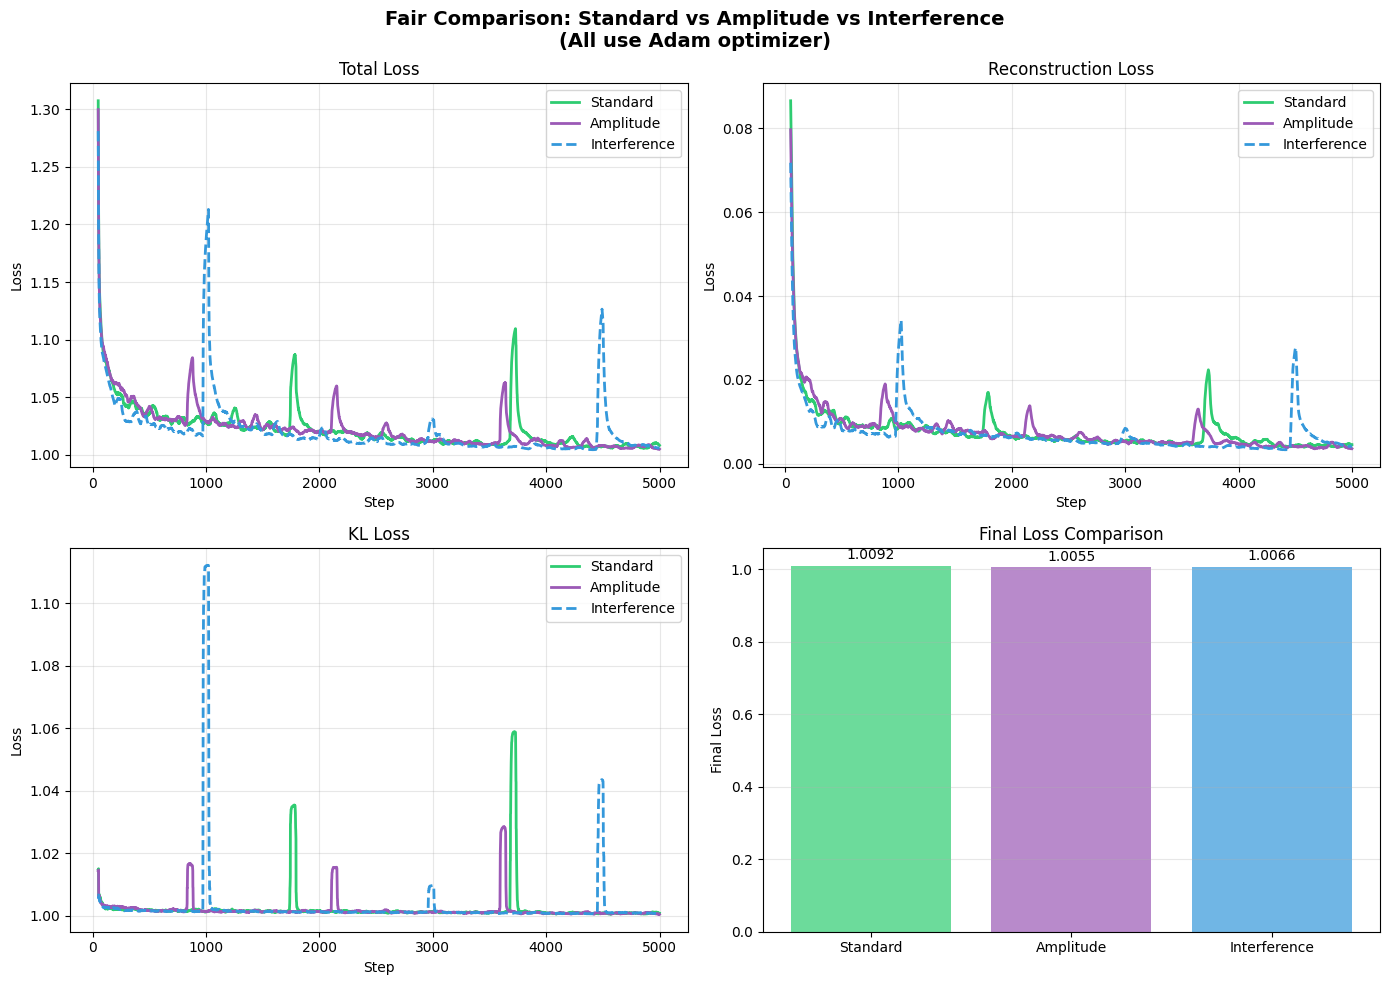

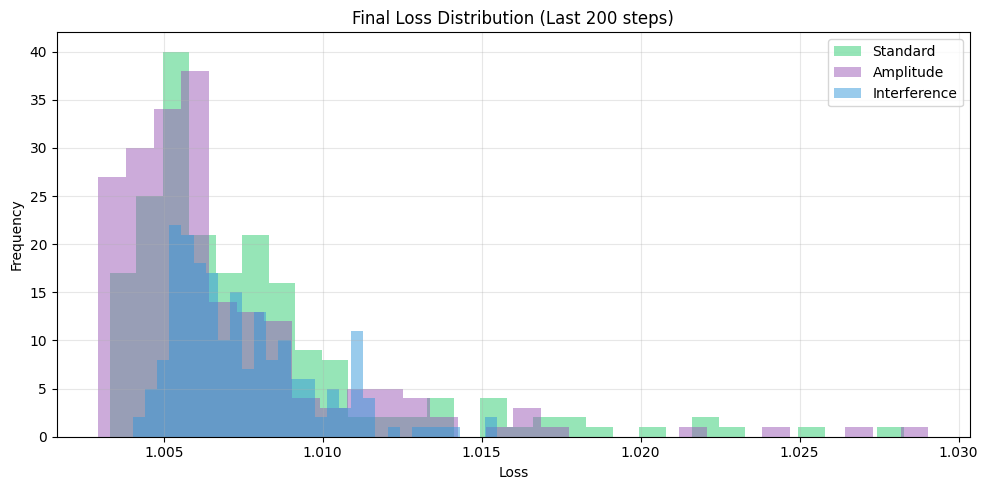

In [65]:
"""
Cell: Comparison Plots - All Three Methods
Purpose: Visualize Standard vs Amplitude vs Interference
"""

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
window = 50

# Colors for three methods
color_std = COLORS['baseline']
color_amp = COLORS['superposition']
color_int = COLORS['qaoa']  # Use different color for interference

# Total loss
ax = axes[0, 0]
ax.plot(standard_history['total'].rolling(window).mean(), 
       color=color_std, label='Standard', linewidth=2)
ax.plot(amplitude_history['total'].rolling(window).mean(),
       color=color_amp, label='Amplitude', linewidth=2)
ax.plot(interference_history['total'].rolling(window).mean(),
       color=color_int, label='Interference', linewidth=2, linestyle='--')
ax.set_xlabel('Step'); ax.set_ylabel('Loss'); ax.set_title('Total Loss')
ax.legend(); ax.grid(True, alpha=0.3)

# Reconstruction loss
ax = axes[0, 1]
ax.plot(standard_history['recon'].rolling(window).mean(),
       color=color_std, label='Standard', linewidth=2)
ax.plot(amplitude_history['recon'].rolling(window).mean(),
       color=color_amp, label='Amplitude', linewidth=2)
ax.plot(interference_history['recon'].rolling(window).mean(),
       color=color_int, label='Interference', linewidth=2, linestyle='--')
ax.set_xlabel('Step'); ax.set_ylabel('Loss'); ax.set_title('Reconstruction Loss')
ax.legend(); ax.grid(True, alpha=0.3)

# KL loss
ax = axes[1, 0]
ax.plot(standard_history['kl'].rolling(window).mean(),
       color=color_std, label='Standard', linewidth=2)
ax.plot(amplitude_history['kl'].rolling(window).mean(),
       color=color_amp, label='Amplitude', linewidth=2)
ax.plot(interference_history['kl'].rolling(window).mean(),
       color=color_int, label='Interference', linewidth=2, linestyle='--')
ax.set_xlabel('Step'); ax.set_ylabel('Loss'); ax.set_title('KL Loss')
ax.legend(); ax.grid(True, alpha=0.3)

# Bar chart comparison
ax = axes[1, 1]
methods = ['Standard', 'Amplitude', 'Interference']
losses = [standard_final_loss, amplitude_final_loss, interference_final_loss]
colors = [color_std, color_amp, color_int]
bars = ax.bar(methods, losses, color=colors, alpha=0.7)
ax.set_ylabel('Final Loss')
ax.set_title('Final Loss Comparison')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, loss in zip(bars, losses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
           f'{loss:.4f}', ha='center', va='bottom', fontsize=10)

fig.suptitle('Fair Comparison: Standard vs Amplitude vs Interference\n(All use Adam optimizer)', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Additional plot: Final loss distributions
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(standard_history['total'].iloc[-200:], bins=30, alpha=0.5, 
       color=color_std, label='Standard')
ax.hist(amplitude_history['total'].iloc[-200:], bins=30, alpha=0.5,
       color=color_amp, label='Amplitude')
ax.hist(interference_history['total'].iloc[-200:], bins=30, alpha=0.5,
       color=color_int, label='Interference')
ax.set_xlabel('Loss'); ax.set_ylabel('Frequency')
ax.set_title('Final Loss Distribution (Last 200 steps)')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 10. Summary

In [66]:
"""
Cell: Save and Summary
Purpose: Save results and display comprehensive summary
"""

# Save results
results_dir = PROJECT_ROOT / "experiments" / "results" / "superposition"
results_dir.mkdir(parents=True, exist_ok=True)

# Save all three models
for name, model, history in [
    ("standard", standard_model, standard_history),
    ("amplitude", amplitude_model, amplitude_history),
    ("interference", interference_model, interference_history)
]:
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'config': {
            'method': name,
            'obs_dim': 4, 'action_dim': 2,
            'stoch_dim': 64, 'deter_dim': 512, 'hidden_dim': 512,
            'learning_rate': 3e-4, 'batch_size': 32, 'seq_len': 20,
            'num_steps': 5000, 'optimizer': 'Adam',
            'parallel_samples': 4 if name == 'interference' else 1,
            'interference_strength': 0.3 if name == 'interference' else 0,
            'version': 'fair_comparison_v3'
        },
        'final_loss': history['total'].iloc[-100:].mean(),
    }
    torch.save(checkpoint, results_dir / f"cartpole_{name}.pt")
    history.to_csv(results_dir / f"{name}_history.csv", index=False)

# Save comparison results
import json

def convert_to_serializable(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, (np.floating, float)):
        return float(obj)
    elif isinstance(obj, (np.integer, int)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

with open(results_dir / "comparison_results.json", 'w') as f:
    json_results = convert_to_serializable(comparison_results)
    json.dump(json_results, f, indent=2)

print("="*70)
print("PHASE 4 COMPLETE: SUPERPOSITION-ENHANCED REPLAY (FINAL)")
print("="*70)

print("\n[1] CRITICAL FIX APPLIED")
print("    Previous: Standard used Adam, Superposition used manual SGD (UNFAIR)")
print("    Fixed: ALL methods now use Adam optimizer (FAIR comparison)")

print("\n[2] THREE METHODS COMPARED")
print("    1. Standard:     Uniform random sampling + Adam")
print("    2. Amplitude:    Amplitude-weighted sampling + Adam")
print("    3. Interference: Gradient interference + Adam")

print("\n[3] WHAT EACH METHOD TESTS")
print("    - Standard vs Amplitude: Tests PURE REPLAY enhancement")
print("    - Standard vs Interference: Tests FULL quantum approach")
print("    - Amplitude vs Interference: Tests gradient interference benefit")

print("\n[4] RESULTS")
print(f"    Standard Loss:     {standard_final_loss:.4f}")
print(f"    Amplitude Loss:    {amplitude_final_loss:.4f}")
print(f"    Interference Loss: {interference_final_loss:.4f}")

print("\n[5] STATISTICAL ANALYSIS")
print(f"    Amplitude vs Standard:")
print(f"      Winner: {comp_amp_vs_std['winner']}, p={comp_amp_vs_std['p_value']:.4f}")
print(f"    Interference vs Standard:")
print(f"      Winner: {comp_int_vs_std['winner']}, p={comp_int_vs_std['p_value']:.4f}")
print(f"    Interference vs Amplitude:")
print(f"      Winner: {comp_int_vs_amp['winner']}, p={comp_int_vs_amp['p_value']:.4f}")

# Determine overall findings
print("\n[6] FINDINGS FOR DISSERTATION")
amp_helps = comp_amp_vs_std['mean1'] < comp_amp_vs_std['mean2']
int_helps = comp_int_vs_std['mean1'] < comp_int_vs_std['mean2']
int_over_amp = comp_int_vs_amp['mean1'] < comp_int_vs_amp['mean2']

print(f"    Amplitude-weighted sampling helps: {'YES' if amp_helps else 'NO'}")
print(f"    Gradient interference helps: {'YES' if int_helps else 'NO'}")
print(f"    Interference improves over amplitude-only: {'YES' if int_over_amp else 'NO'}")

print(f"\n[7] Results saved to: {results_dir}")

print("\n" + "="*70)
print("NEXT: Phase 5 - Gate-Enhanced Neural Layers")
print("="*70)
print("""
In Phase 5, we will:
  1. Implement quantum gate-inspired neural layers
  2. Add Hadamard-like transformations
  3. Create CNOT-inspired interactions
  4. Compare with standard neural layers

This tests a DIFFERENT quantum-inspired enhancement:
  - Phase 4 (this): Enhanced REPLAY BUFFER
  - Phase 5 (next): Enhanced NEURAL ARCHITECTURE
""")



PHASE 4 COMPLETE: SUPERPOSITION-ENHANCED REPLAY (FINAL)

[1] CRITICAL FIX APPLIED
    Previous: Standard used Adam, Superposition used manual SGD (UNFAIR)
    Fixed: ALL methods now use Adam optimizer (FAIR comparison)

[2] THREE METHODS COMPARED
    1. Standard:     Uniform random sampling + Adam
    2. Amplitude:    Amplitude-weighted sampling + Adam
    3. Interference: Gradient interference + Adam

[3] WHAT EACH METHOD TESTS
    - Standard vs Amplitude: Tests PURE REPLAY enhancement
    - Standard vs Interference: Tests FULL quantum approach
    - Amplitude vs Interference: Tests gradient interference benefit

[4] RESULTS
    Standard Loss:     1.0092
    Amplitude Loss:    1.0055
    Interference Loss: 1.0066

[5] STATISTICAL ANALYSIS
    Amplitude vs Standard:
      Winner: Amplitude, p=0.0000
    Interference vs Standard:
      Winner: Interference, p=0.0000
    Interference vs Amplitude:
      Winner: Amplitude, p=0.0000

[6] FINDINGS FOR DISSERTATION
    Amplitude-weighted sam